In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<h4> prepare_data.py </h4>

In [ ]:
# 
import os
import urllib.request # download
import zipfile    # unzip, zip extract...
import tarfile    # file .tar
 
data_dir = '/content/drive/MyDrive/BK_AI/Object Detection/data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
saved_path = os.path.join(data_dir, '/VOCtrainval_11-May-2012.tar')
data_path = os.path.join(data_dir, 'VOCdevkit')

if not os.path.exists(data_path):
    urllib.request.urlretrieve(url, saved_path)
    tar = tarfile.TarFile(saved_path)
    tar.extractall(path=data_dir)
    tar.close()
    os.remove(path=saved_path)
    print('done')

<h4> lib.py </h4>

In [ ]:
!pip install pytorch==1.4.0
!pip install torchvision==0.5.0

ERROR: Could not find a version that satisfies the requirement pytorch==1.4.0 (from versions: 0.1.2, 1.0.2)
ERROR: No matching distribution found for pytorch==1.4.0
     |████████████████████████████████| 4.0 MB 8.8 MB/s 
     |████████████████████████████████| 753.4 MB 6.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.


In [ ]:
import os
import glob
import random
import cv2
from PIL import Image
import xml.etree.ElementTree as ET    # Xử lý file xml
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torch.autograd import Function
import torch.optim as optim
import torch.utils.data
from google.colab.patches import cv2_imshow
from math import sqrt

import itertools
import pandas
import time
from tqdm import tqdm
import sys

torch.manual_seed(43)
np.random.seed(43)
random.seed(43)

torch.backends.cudnn.benchmark = True       # Train nhanh hơn

<h4> config.py </h4>

In [ ]:
root_path = '/content/drive/MyDrive/BK_AI/Object Detection/data/VOCdevkit/VOC2012'

def get_classes(path):
    classes_path = os.path.join(path, 'classes.txt')
    classes = []
    with open(classes_path, 'r') as f:
        for line in f:
            classes.append(line.strip())
    return classes

classes = get_classes(root_path)
print(classes)
input_size = 300
color_mean=(104, 117, 123)
batch_size = 2

num_offset = 4
bbox_ratio_num = [4, 6, 6, 6, 4, 4]

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


<h4> utils.py </h4>

In [ ]:
# Chuẩn bị đường dẫn:
def make_data_path(root_path, phase='all'):    # Trả về list các đường dẫn tới (ảnh, bbox)
    img_path_template = os.path.join(root_path, 'JPEGImages', '{}.jpg')
    annotation_path_template = os.path.join(root_path, 'Annotations', '{}.xml')

    train_info_path = os.path.join(root_path, 'ImageSets/Main/train.txt')
    val_info_path = os.path.join(root_path, 'ImageSets/Main/val.txt')

    train_img_list = []
    train_anno_list = []
    val_img_list = []
    val_anno_list = []

    for line in open(train_info_path):
        file_id = line.strip() # Xoá \n, space
        img_path = img_path_template.format(file_id)
        anno_path = annotation_path_template.format(file_id)

        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    for line in open(val_info_path):
        file_id = line.strip()
        img_path = img_path_template.format(file_id)
        anno_path = annotation_path_template.format(file_id)

        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    if phase == 'all':
        return (train_img_list, train_anno_list, val_img_list, val_anno_list)
    elif phase == 'train':
        return (train_img_list, train_anno_list)
    elif phase == 'val':
        return (val_img_list, val_anno_list)
    return None
    
train_img_path, train_anno_path, val_img_path, val_anno_path = make_data_path(root_path, phase='all')
print(len(train_img_path))

train_img_path[len(train_img_path)-1]

5717


'/content/drive/MyDrive/BK_AI/Object Detection/data/VOCdevkit/VOC2012/JPEGImages/2011_003276.jpg'

In [ ]:
"""
  Extract thông tin từ file .xml
"""
# img = Image.open('/content/drive/MyDrive/BK_AI/Object Detection/img/xml_format.png')
# plt.figure(figsize=(20,10))
# plt.imshow(img)
# plt.show()

class XMLAnnotation(object):    # kế thừa từ class object
    def __init__(self, classes):
        self.classes = classes

    def __call__(self, xml_path):
        # include image annotation
        res = []
        # read file xml
        xml = ET.parse(xml_path).getroot()
        width = int(xml.find('size').find('width').text.strip())
        height = int(xml.find('size').find('height').text.strip())
        depth = int(xml.find('size').find('depth').text.strip())
        file_id = xml.find('filename').text
        # print(height, width, file_id)     

        for obj in xml.iter('object'):    # Duyệt hết các phần tử trong <object>
            difficult = int(obj.find('difficult').text)   # Chỉ độ khó để có thể dùng cho việc trainning
            if difficult == 1:
                continue
             # information for bound boxes
            bndbox =[]
            name = obj.find('name').text.lower().strip()
            class_id = self.classes.index(name)
            bbox = obj.find('bndbox')
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in pts:
                pixel = int(bbox.find(pt).text)
                pixel -= 1      # Vì data trong VOC bắt đầu từ (1, 1) thay vì (0, 0)
                # Lấy toạ độ theo tỉ lệ
                if pt == 'xmin' or pt == 'xmax':
                    pixel /= width  # ratio of width
                else:
                    pixel /= height # ratio of height
                bndbox.append(pixel)
            bndbox.append(class_id)
            res += [bndbox]
        return np.array(res)    # [[xmin, ymin,xmax, ymax, class_id]...]
          
# xml_anno = XMLAnnotation(classes)
# res = xml_anno(train_anno_path[0])
# print(res)
# img = cv2.imread(train_img_path[0])
# h, w, c = img.shape
# for box in res:
#     x1, y1, x2, y2 = map(int, (box[0]*w, box[1]*h, box[2]*w, box[3]*h))
#     print(x1, y1, x2, y2)
#     img = cv2.rectangle(img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=2)
# # cv2.rectangle()
# cv2_imshow(img)

# cv2.waitKey(0)

<h4> DataAugmentation.py </h4>

In [ ]:
import torch
from torchvision import transforms
import cv2
import numpy as np
import types
from numpy import random


def intersect(box_a, box_b):
    max_xy = np.minimum(box_a[:, 2:], box_b[2:])
    min_xy = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]


def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: Multiple bounding boxes, Shape: [num_boxes,4]
        box_b: Single bounding box, Shape: [4]
    Return:
        jaccard overlap: Shape: [box_a.shape[0], box_a.shape[1]]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1]))  # [A,B]
    area_b = ((box_b[2]-box_b[0]) *
              (box_b[3]-box_b[1]))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


class Compose(object):
    """Composes several augmentations together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> augmentations.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels


class Lambda(object):
    """Applies a lambda as a transform."""

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img, boxes=None, labels=None):
        return self.lambd(img, boxes, labels)


class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels


class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels


class ToAbsoluteCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] *= width
        boxes[:, 2] *= width
        boxes[:, 1] *= height
        boxes[:, 3] *= height

        return image, boxes, labels


class ToPercentCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] /= width
        boxes[:, 2] /= width
        boxes[:, 1] /= height
        boxes[:, 3] /= height

        return image, boxes, labels


class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image, boxes, labels


class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image, boxes, labels


class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, boxes, labels


class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, boxes, labels


class ConvertColor(object):
    def __init__(self, current='BGR', transform='HSV'):
        self.transform = transform
        self.current = current

    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image, boxes, labels


class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image, boxes, labels


class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, boxes, labels


class ToCV2Image(object):
    def __call__(self, tensor, boxes=None, labels=None):
        return tensor.cpu().numpy().astype(np.float32).transpose((1, 2, 0)), boxes, labels


class ToTensor(object):
    def __call__(self, cvimage, boxes=None, labels=None):
        return torch.from_numpy(cvimage.astype(np.float32)).permute(2, 0, 1), boxes, labels


class RandomSampleCrop(object):
    """Crop
    Arguments:
        img (Image): the image being input during training
        boxes (Tensor): the original bounding boxes in pt form
        labels (Tensor): the class labels for each bbox
        mode (float tuple): the min and max jaccard overlaps
    Return:
        (img, boxes, classes)
            img (Image): the cropped image
            boxes (Tensor): the adjusted bounding boxes in pt form
            labels (Tensor): the class labels for each bbox
    """
    def __init__(self):
        self.sample_options = (
            # using entire original input image
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # randomly sample a patch
            # (None, None),
        )

    def __call__(self, image, boxes=None, labels=None):
        height, width, _ = image.shape
        while True:
            # randomly choose a mode
            random_idx = random.randint(0, len(self.sample_options) - 1)
            mode = self.sample_options[random_idx]
            # mode = self.sample_options[4]
            # print('MODE: ', mode)
            if mode is None:
                return image, boxes, labels

            min_iou, max_iou = mode
            if min_iou is None:
                min_iou = float('-inf')
            if max_iou is None:
                max_iou = float('inf')

            # max trails (50)
            for _ in range(50):
                current_image = image

                w = random.uniform(0.3 * width, width)
                h = random.uniform(0.3 * height, height)

                # aspect ratio constraint b/t .5 & 2
                if h / w < 0.5 or h / w > 2:
                    continue

                left = random.uniform(width - w)
                top = random.uniform(height - h)

                # convert to integer rect x1,y1,x2,y2
                rect = np.array([int(left), int(top), int(left+w), int(top+h)])

                # calculate IoU (jaccard overlap) b/t the cropped and gt boxes
                overlap = jaccard_numpy(boxes, rect)

                # is min and max overlap constraint satisfied? if not try again
                if overlap.min() < min_iou and max_iou < overlap.max():
                    continue

                # cut the crop from the image
                current_image = current_image[rect[1]:rect[3], rect[0]:rect[2],
                                              :]

                # keep overlap with gt box IF center in sampled patch
                centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0

                # mask in all gt boxes that above and to the left of centers
                m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])

                # mask in all gt boxes that under and to the right of centers
                m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

                # mask in that both m1 and m2 are true
                mask = m1 * m2

                # have any valid boxes? try again if not
                if not mask.any():
                    continue

                # take only matching gt boxes
                current_boxes = boxes[mask, :].copy()

                # take only matching gt labels
                current_labels = labels[mask]

                # should we use the box left and top corner or the crop's
                current_boxes[:, :2] = np.maximum(current_boxes[:, :2],
                                                  rect[:2])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, :2] -= rect[:2]

                current_boxes[:, 2:] = np.minimum(current_boxes[:, 2:],
                                                  rect[2:])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, 2:] -= rect[:2]

                return current_image, current_boxes, current_labels


class Expand(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, image, boxes, labels):
        if random.randint(2):
            return image, boxes, labels

        height, width, depth = image.shape
        ratio = random.uniform(1, 4)
        left = random.uniform(0, width*ratio - width)
        top = random.uniform(0, height*ratio - height)

        expand_image = np.zeros(
            (int(height*ratio), int(width*ratio), depth),
            dtype=image.dtype)
        expand_image[:, :, :] = self.mean
        expand_image[int(top):int(top + height),
                     int(left):int(left + width)] = image
        image = expand_image

        boxes = boxes.copy()
        boxes[:, :2] += (int(left), int(top))
        boxes[:, 2:] += (int(left), int(top))

        return image, boxes, labels


class RandomMirror(object):
    def __call__(self, image, boxes, classes):
        _, width, _ = image.shape
        if random.randint(2):
            image = image[:, ::-1]
            boxes = boxes.copy()
            boxes[:, 0::2] = width - boxes[:, 2::-2]
        return image, boxes, classes


class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image


class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),
            ConvertColor(transform='HSV'),
            RandomSaturation(),
            RandomHue(),
            ConvertColor(current='HSV', transform='BGR'),
            RandomContrast()
        ]
        self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomLightingNoise()

    def __call__(self, image, boxes, labels):
        im = image.copy()
        im, boxes, labels = self.rand_brightness(im, boxes, labels)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, boxes, labels = distort(im, boxes, labels)
        return self.rand_light_noise(im, boxes, labels)


class SSDAugmentation(object):
    def __init__(self, size=300, mean=(104, 117, 123)):
        self.mean = mean
        self.size = size
        self.augment = Compose([
            ConvertFromInts(),
            ToAbsoluteCoords(),
            PhotometricDistort(),
            Expand(self.mean),
            RandomSampleCrop(),
            RandomMirror(),
            ToPercentCoords(),
            Resize(self.size),
            SubtractMeans(self.mean)
        ])

    def __call__(self, img, boxes, labels):
        return self.augment(img, boxes, labels)


def test_transform_function(img_path, anno_path, transform):
    img = cv2.imread(img_path)
    h, w, c = img.shape
    bboxes_label_list = XMLAnnotation(classes)(train_anno_path[0])
    # for b in bboxes_label_list:
    #     x1, y1, x2, y2 = map(int, (b[0]*w, b[1]*h, b[2]*w, b[3]*h))
    #     img1 = cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)
    # cv2_imshow(img)
    # img = cv2.imread(img_path)
    bboxes = np.array(bboxes_label_list[:,:-1])
    bboxes[:,0] *= w
    bboxes[:,1] *= h
    bboxes[:,2] *= w
    bboxes[:,3] *= h
    labels = np.array(bboxes_label_list[:,-1])

    if transform == 'expand':
    # After Expand:
        expand = Expand(mean=color_mean) 
        img, bboxes, labels = expand(img, bboxes, labels)
        print(bboxes)
        for b in bboxes:
            x1, y1, x2, y2 = map(int, (b[0], b[1], b[2], b[3]))
            img2 = cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)
        # stack = np.hstack((img1, img2))
        cv2_imshow(img2)
        cv2.waitKey(0)
    elif transform == 'mirror':
        mirror = RandomMirror()
        img, bboxes, labels = mirror(img, bboxes, labels)
        print(bboxes)
        for b in bboxes:
            x1, y1, x2, y2 = map(int, (b[0], b[1], b[2], b[3]))
            img2 = cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)
        # stack = np.hstack((img1, img2))
        print(img2.shape)
        cv2_imshow(img2)
        cv2.waitKey(0)
    elif transform == 'randomsamplecrop':
        rsc = RandomSampleCrop()
        img, bboxes, labels = rsc(img, bboxes, labels)
        print(bboxes)
        for b in bboxes:
            x1, y1, x2, y2 = map(int, (b[0], b[1], b[2], b[3]))
            img2 = cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)
        # stack = np.hstack((img1, img2))
        print(img2.shape)
        cv2_imshow(img2)
        cv2.waitKey(0)

[[128. 184. 546. 517.]
 [233. 141. 364. 264.]]


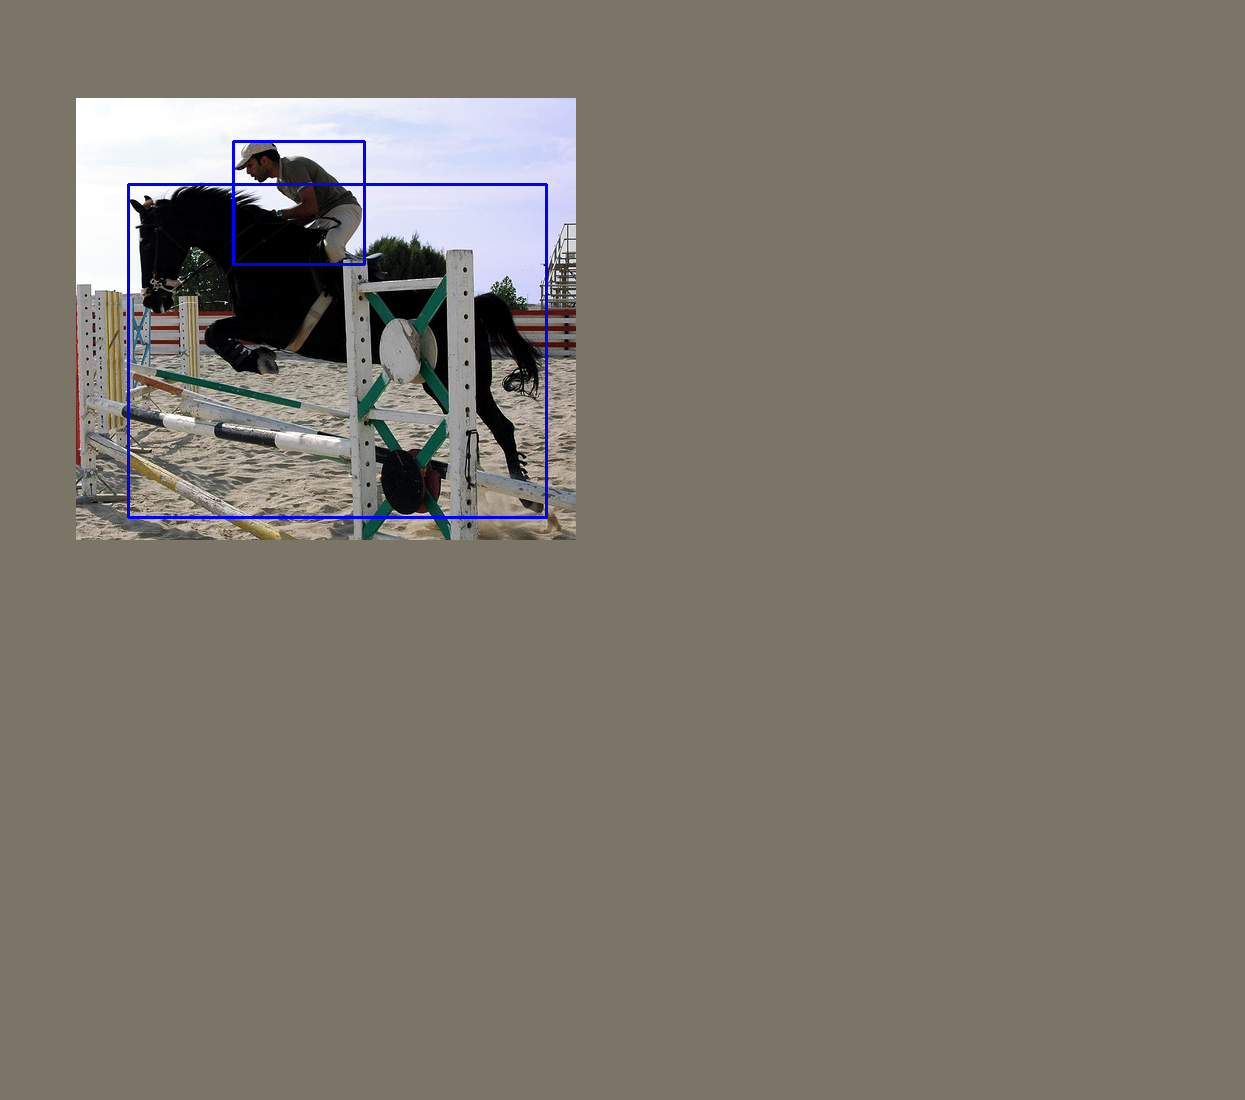

In [ ]:
test_transform_function(train_img_path[0], train_anno_path[0], 'expand')

[[  0.  66. 264. 398.]
 [ 78.  23. 209. 146.]]
(398, 264, 3)


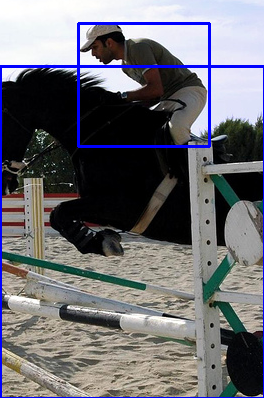

In [ ]:
test_transform_function(train_img_path[0], train_anno_path[0], 'randomsamplecrop')

<h4> Dataset.py </h4>
<ul>
    <li> Datatransform: Tiền xử lý ảnh và annotation </li>
    <li> Lúc Training: có random -> augmentation </li>
    <li> Khi xoay ảnh, cần xoay luôn bounding box </li>
    <li> Lúc test: Chỉ resize... </li>

</ul>

(300, 300, 3)


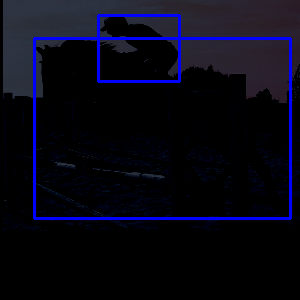

In [ ]:
"""
    Data Transformation
"""
class DataTransform():
    def __init__(self, input_size, color_mean):        # color_mean: chuẩn hoá (r, g, b) về mean = color_mean
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),          # Chuyển ảnh -> float32, bboxes, label giữ nguyên
                ToAbsoluteCoords(),         # Trả về boxes annotation từ ratio [0, 1] -> normal
                PhotometricDistort(),       # Biến đổi color của ảnh
                Expand(color_mean),         # Padding thêm vào 4 phía của ảnh 1 đại lượng mean, đồng thời dịch chuyển các boxes
                RandomSampleCrop(),         # Random crop ảnh
                RandomMirror(),             # Xoay ảnh ngược lại = RandomHorizontalFlip()
                ToPercentCoords(),          # Chuẩn hoá boxes về [0, 1]
                Resize(input_size),         # Resize -> input_size(300*300)    
                SubtractMeans(color_mean)   # Chuẩn hoá 3 channel BGR về mean=(..,..,..)
            ]),
            'val': Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }

    def __call__(self, img, boxes, labels, phase='train'):
        return self.data_transform[phase](img, boxes, labels)


def test_datatransform(img_path, anno_path, phase='train'):
    img = cv2.imread(img_path)
    xml = XMLAnnotation(classes)
    boxes_labels = xml(anno_path)
    boxes = boxes_labels[:,:-1]
    labels = boxes_labels[:, -1]

    input_size = 300
    color_mean=(104, 117, 123)

    transform = DataTransform(input_size=input_size, color_mean=color_mean)
    img, boxes, labels = transform(img, boxes, labels, phase)
    for b in boxes:
        x1, y1, x2, y2 = map(lambda x: int(x*input_size), (b[0], b[1], b[2], b[3]))
        img2 = cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)
    # stack = np.hstack((img1, img2))
    print(img2.shape)
    cv2_imshow(img2)
    cv2.waitKey(0)


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_path_list, anno_path_list, transform, phase, anno_xml):
        self.img_path_list = img_path_list
        self.anno_path_list = anno_path_list
        self.transform = transform
        self.anno_xml = anno_xml
        self.phase = phase

    def __len__(self):
        return len(self.img_path_list)

    def pull_item(self, idx):
        img_file_path = self.img_path_list[idx]
        img = cv2.imread(img_file_path) #BGR
        height, width, channels = img.shape

        # get anno information
        anno_file_path = self.anno_path_list[idx]
        ann_info = self.anno_xml(anno_file_path)

        # preprocessing
        boxes, labels = ann_info[:, :-1], ann_info[:, -1]
        img, boxes, labels = self.transform(img, boxes, labels, self.phase)

        # BGR -> RGB, (height, width, channels) -> (channels, height, width)
        img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)

        # ground truth
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        return img, gt

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            start, stop, step = idx.indices(len(self))
            # print(start, stop, step)
            res = []
            while start < stop:
                img, groundtruth = self.pull_item(start)
                res.append([img, groundtruth])
                start += step
            return res
        img, groundtruth = self.pull_item(idx)
        return img, groundtruth

test_datatransform(train_img_path[0], train_anno_path[0])

In [ ]:
transform = DataTransform(input_size=input_size, color_mean=color_mean)
anno_xml = XMLAnnotation(classes)

trainset = MyDataset(train_img_path, train_anno_path, transform, 'train', anno_xml)
valset = MyDataset(val_img_path, val_anno_path, transform, 'val', anno_xml)
# print('Length Traindataset: ', len(trainset))
# idx0 = trainset[0][0].numpy().transpose(1, 2, 0)       # (c, h, w) -> (h, w, c)
# idx0 = idx0[:,:,[2, 1, 0]]           # RGB -> BGR
# # print('idx0: ', idx0)
# # print('Dataset shape: ', idx0.shape)
# print('Sample in Traindataset')
# cv2_imshow(idx0)

In [ ]:
# 
def my_collate_fn(batch):       # batch = [[img, anno], ...]
    targets = []
    imgs = []
    # print('---- Test my_collate_fn ----')
    for sample in batch:
        # print('Tensor img shape: ', sample[0].shape)
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))       # Targets = [annotation1, annotation2...]

    # Convert imgs, targets to Tensor: [[3, 300, 300], [3, 300, 300]...] -> (batch_size, 3, 300, 300)
    imgs = torch.stack(imgs, dim=0)
    # targets = torch.stack(targets, dim=0)
    # print('Shape imgs: ', imgs.shape)
    # print('Targets: ', targets)
    return imgs, targets

train_dataloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
# Lúc đánh giá sau mỗi epoch, không thể shuffle vì như thế không fair
val_dataloader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, collate_fn=my_collate_fn)        

dataloader = {
    'train':train_dataloader,
    'val':val_dataloader
}

batch_itor = iter(dataloader['train'])
images, targets = next(batch_itor)
print('Images: ', images.shape)
print('Targets: ', targets)

Images:  torch.Size([2, 3, 300, 300])
Targets:  [tensor([[ 0.0000,  0.0294,  0.5735,  1.0000, 14.0000]]), tensor([[ 0.3585,  0.6252,  0.5119,  0.7331,  1.0000],
        [ 0.2431,  0.5969,  0.3907,  0.7331,  1.0000],
        [ 0.2701,  0.5063,  0.3533,  0.7331, 14.0000]])]


<h2> Mô hình network SSD </h2>
<ul> 
    <img src='https://drive.google.com/uc?id=1F_nut3tQ-NVv6RXf0GVazNGiY94g2nNy'>
    <li> 4 module chính:
        <ul>
            <li> vgg  </li>
            <li> extras  </li>
            <li> loc (location)  </li>
            <li> conf (confidence)  </li>
        </ul>
    </li>
    <li> Input đầu vào của VGG phải thay đổi từ (224, 224) -> (300, 300) và output thay đổi từ (1000)->(19)   </li>
    <li> VGG bỏ đi lớp phân loại Linear </li>
    <li> Sau khi đi qua lớp thứ 10, ta dùng 1 lớp L2Norm cho (512, 38, 38), kết quả được Source1  </li>
    <li> Vẫn lấy kết quả phần extract đặc trưng của vgg, ta được source2  </li>
    <li> Lấy source2 tiếp tục đi qua các khối Conv để được source3 (512*10*10), source4 (256*5*5), source5 (512*3*3), source6 (512*1*1)   </li>
    <li> Đưa 6 source đi qua các ConvLayer để lấy ra Offset của 8732 default box (loc là 1 subnetwork): ([1, 8732, 4])  </li>
    <li> Tiếp tục đưa 8732 db (1 cách song song với loc) qua các ConvLayer để lấy ra 8732 confidence của 21 class: ([1, 8732, 21])  </li>
    <li> Big Feature Map: Feature Map có size lớn -> Có xu hướng detect box nhỏ => SSD có xu hướng: Trong ảnh có obj nhỏ thì khó detect thì Source2 nó chỉ đi qua ít ConvLayer (10 layer)  </li>
    <li> Small Feature Map: Feature Map có size nhỏ -> Có xu hướng detect box lớn  </li>
    <li>Vì sao có 8732 dbox? Mỗi 1 pixel trong FeatureMap (source 1... source 6) đại diện cho thông tin của 1 vùng trong ảnh => Số dB ban đầu: 38*38+...
        Nhưng càng nhiều dB càng tốt => Nhân thêm <br>
        Tại sao lại có hệ số 4, 6? Ví dụ xét FeatureMap sourcr 3, mỗi pixel nó đại diện cho 1 vùng có (ori_size/3, ori_size/3), nhưng ta muốn nó có thể biểu diễn thêm cho 1 số vật thể không là hình vuông (như xe đạp, người...) 
        <img src='https://drive.google.com/uc?id=1-4XL2wHuHgYmwv2cp8r5Veg2AsnTxsN0'> 
    </li>

</ul>

<h3> Model.py </h3>

In [ ]:
def create_vgg_modules_fromdict():
    layers = {}     # List chứa các layer của vgg
    in_channels = 3

    configs_param_vgg = [64, 64, 'MaxF',              # MaxF: MaxPooling with ceiling_mode = Floor
                   128, 128, 'MaxF',
                   256, 256, 256, 'MaxC',       # MaxC: MaxPooling with ceiling_mode = Ceil
                   512, 512, 512, 'MaxF',
                   512, 512, 512, 'MaxS']      # MaxS: MaxPooling but keep same size
    configs_name_vgg = ['conv1', 'conv2', 'maxpool1',
                        'conv3', 'conv4', 'maxpool2',
                        'conv5', 'conv6', 'conv7', 'maxpool3',
                        'conv8', 'conv9', 'conv10', 'maxpool4']
    configs_vgg = [(name, param) for (name, param) in zip(configs_name_vgg, configs_param_vgg)]


    for (name, param) in configs_vgg:
        if param == 'MaxF':
            layers.update({name: nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)})
        elif param == 'MaxC':
            layers.update({name: nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)})
        elif param == 'MaxS':
            layers.update({name: nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=False)})
        else:       # Convolution layer
            layers.update({name: nn.Conv2d(in_channels=in_channels, out_channels=param, kernel_size=(3, 3), stride=1, padding=1, dilation=1, bias=True)})
            layers.update({name.replace('conv', 'relu'): nn.ReLU(inplace=True)})        # inplace=True: Có lưu giá trị input ở lớp ReLU lên thanh memory hay ko? inplace=True <=> Ko lưu
            in_channels = param

    layers.update({'conv14': nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=6, dilation=6, bias=True)})
    layers.update({'relu14': nn.ReLU(inplace=True)})
    layers.update({'conv15': nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1, stride=1, padding=0, dilation=1, bias=True)})
    layers.update({'relu15': nn.ReLU(inplace=True)})
    # print(layers)
    res = nn.ModuleDict()
    for key, module in layers.items():
        res.add_module(key, module)
    return res        # Tạo Module từ 1 Dict


def create_vgg_modules():        # Tạo module từ list
    layers = []
    in_channels = 3

    configs_param_vgg = [64, 64, 'MaxF',              # MaxF: MaxPooling with ceiling_mode = Floor
                   128, 128, 'MaxF',
                   256, 256, 256, 'MaxC',       # MaxC: MaxPooling with ceiling_mode = Ceil
                   512, 512, 512, 'MaxF',
                   512, 512, 512, 'MaxS']      # MaxS: MaxPooling but keep same size
    for cfg in configs_param_vgg:
        if cfg == 'MaxF':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)]
        elif cfg == 'MaxC':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)]
        elif cfg == 'MaxS':
            layers += [nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=False)]
        else:
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=cfg, kernel_size=3, stride=1, padding=1, bias=True, dilation=1)]
            layers += [nn.ReLU(inplace=True)]
            in_channels = cfg
    conv14 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=6, dilation=6, bias=True)
    relu14 = nn.ReLU(inplace=True)
    conv15 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1, stride=1, padding=0, dilation=1, bias=True)
    relu15 = nn.ReLU(inplace=True)
    layers += [conv14, relu14, conv15, relu15]
    return nn.ModuleList(layers)


def create_extras_module():
    layers = []
    in_channels = 1024
    cfgs = [256, 512,
            128, 256,
            128, 256,
            128, 256]

    def conv2d_relu_module(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=True, inplace=True):
        conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias)
        relu = nn.ReLU(inplace=inplace)
        return [conv, relu]


    layers += conv2d_relu_module(in_channels, cfgs[0])
    layers += conv2d_relu_module(cfgs[0], cfgs[1], 3, 2, 1)
    layers += conv2d_relu_module(cfgs[1], cfgs[2])
    layers += conv2d_relu_module(cfgs[2], cfgs[3], 3, 2, 1)
    layers += conv2d_relu_module(cfgs[3], cfgs[4])
    layers += conv2d_relu_module(cfgs[4], cfgs[5], 3)
    layers += conv2d_relu_module(cfgs[5], cfgs[6])
    layers += conv2d_relu_module(cfgs[6], cfgs[7], 3)
    return nn.ModuleList(layers)


def create_loc_conf_module(bbox_ratio_num, num_classes=21, num_offset=4):
    loc_layers = []
    conf_layers = []

    """
        Loc subnetwork
    """
    loc_layers += [nn.Conv2d(in_channels=512, out_channels= bbox_ratio_num[0]*num_offset, kernel_size=3, padding=1)]        # Input: Source1
    loc_layers += [nn.Conv2d(in_channels=1024, out_channels= bbox_ratio_num[1]*num_offset, kernel_size=3, padding=1)]        # Input: Source2
    loc_layers += [nn.Conv2d(in_channels=512, out_channels= bbox_ratio_num[2]*num_offset, kernel_size=3, padding=1)]        # Input: Source3
    loc_layers += [nn.Conv2d(in_channels=256, out_channels= bbox_ratio_num[3]*num_offset, kernel_size=3, padding=1)]        # Input: Source4
    loc_layers += [nn.Conv2d(in_channels=256, out_channels= bbox_ratio_num[4]*num_offset, kernel_size=3, padding=1)]        # Input: Source5
    loc_layers += [nn.Conv2d(in_channels=256, out_channels= bbox_ratio_num[5]*num_offset, kernel_size=3, padding=1)]        # Input: Source6
    loc_module = nn.ModuleList(loc_layers)

    """
        Conf subnetwork
    """
    conf_layers += [nn.Conv2d(in_channels=512, out_channels= bbox_ratio_num[0]*num_classes, kernel_size=3, padding=1)]        # Input: Source1
    conf_layers += [nn.Conv2d(in_channels=1024, out_channels= bbox_ratio_num[1]*num_classes, kernel_size=3, padding=1)]        # Input: Source2
    conf_layers += [nn.Conv2d(in_channels=512, out_channels= bbox_ratio_num[2]*num_classes, kernel_size=3, padding=1)]        # Input: Source3
    conf_layers += [nn.Conv2d(in_channels=256, out_channels= bbox_ratio_num[3]*num_classes, kernel_size=3, padding=1)]           # Input: Source4
    conf_layers += [nn.Conv2d(in_channels=256, out_channels= bbox_ratio_num[4]*num_classes, kernel_size=3, padding=1)]        # Input: Source5
    conf_layers += [nn.Conv2d(in_channels=256, out_channels= bbox_ratio_num[5]*num_classes , kernel_size=3, padding=1)]        # Input: Source6
    conf_module = nn.ModuleList(conf_layers)
    return loc_module, conf_module

vgg = create_vgg_modules()
extras = create_extras_module()
loc, conf = create_loc_conf_module(bbox_ratio_num=bbox_ratio_num, num_classes=len(classes)+1, num_offset=num_offset)
vgg, extras, loc, conf

(ModuleList(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
   (17): Conv2d(2

In [ ]:
def test_lnorm(x):
    # L0Norm:
    l0norm = np.linalg.norm(x, ord=0)
    l1norm = np.linalg.norm(x, ord=1)
    l2norm = np.linalg.norm(x, ord=2)
    print(l0norm, l1norm, l2norm)

class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=1e-2):       # scale???: 
        super(L2Norm, self).__init__()      # super(ClassName, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale      # Hệ số để nhân với weight
        self.reset_parameter()  # Reset lại weight
        self.eps = 1e-10        # Loại đi exception chia cho 0

    def reset_parameter(self):
        nn.init.constant_(self.weight, self.scale)     # Khởi tạo self.weight = self.scale với mọi w

    def forward(self, x):
        # L2Norm:
        # x = (batch_size, c, h, w) => x = x/norm
        norm = x.pow(2).sum(dim=1, keepdim=False).sqrt() + self.eps         # x^2 => Tính tổng chỉ theo channels => norm = (Batch_size, H, W) trong đó H = sigma(i^2) với i=1->h
        norm = norm.unsqueeze(dim=1)                                        # tương đương với keepdim
        x = torch.div(x, norm)
        # weight.size() = (512) -> cần: (1, 512, 1, 1)
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        # (1, 512, 1, 1) -> (batchsize, 512, h, w)
        weights = weights.expand_as(x)          # Mỗi channel (lát cắt theo chiều cao) sẽ có chung 1 bộ tham số (w, w, w...w), mỗi instance có cùng chung weight như nhau
        x = weights*x
        return x

l2norm = L2Norm(input_channels=3)

In [ ]:
# x = torch.Tensor(np.random.randint(low=0, high=3, size=(2, 2, 1, 1)))
# print(x)
# y = x.sum(dim=0, keepdim=True)
# z = x.sum(dim=0).unsqueeze(dim=0)
# print(y.shape)
# print(z.shape)
# print(y)
# print(y-z)
# w = torch.Tensor(2).unsqueeze(0).unsqueeze(2).unsqueeze(3)
# w = w.expand_as(x)
# w

<h3> config.py </h3>

In [ ]:
cfg_dbox = {
    'num_classes': len(classes)+1,          # 20 class + 1 background
    'input_size': 300,                      # Input đưa vào SSD
    'bbox_ratio_num': [4, 6, 6, 6, 4, 4],    # Tỉ lệ khung hình: Ứng với 1 featuremaps có 4, 6, ... khung hình
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 30, 60, 100, 300],     # Size of default box: steps[i] = input_size/feature_maps[i]
    'min_size': [30, 60, 111, 162, 213, 264],  # Min size of default box
    'max_size': [60, 111, 162, 213, 264, 315],   # Max size of default box
    'min_scale_paper': 0.2,
    'max_scale_paper': 0.9,
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],       # ar = 2, ar = 3
    'aspect_ratios_paper': [[1, 2, 3, 1/2, 1/3], [1, 2, 1/2]]      
}

<h3> utils.py </h3>

In [ ]:
"""
    Khởi tạo 8732 default box trong SSD
"""

class DefaultBox():
    def __init__(self, cfg, paper=False):
        self.img_size = cfg['input_size']
        self.feature_maps = cfg['feature_maps']
        self.steps = cfg['steps']
        self.min_size = cfg['min_size']
        self.max_size = cfg['max_size']
        self.smin = cfg['min_scale_paper']
        self.smax = cfg['max_scale_paper']
        self.aspect_ratios = cfg['aspect_ratios']
        self.aspect_ratios_paper = cfg['aspect_ratios_paper']
        self.paper = paper
        self.m = 6      # 6 Loại featuremaps

    def cal_sk(self, k):
        return self.smin + (self.smax-self.smin)/(self.m-1) * (k-1)

    def create_defaultbox(self):
        default_boxes = []
        for k, f in enumerate(self.feature_maps):       # k: 0->5
            for (i, j) in itertools.product(range(f), repeat=2):      # (i, j): Toạ độ trong 1 featuremap <=> 1 receptive field ở ảnh gốc ban đầu
                f_k = f                     # f_k: size of featuremaps
                center_x = (j+0.5)/f_k      # center(x, y): tính theo ratio của featuremaps
                center_y = (i+0.5)/f_k

                # Tính s_k, w_k, h_k: Scale, width, height of default box thứ k (feature maps thứ k (source thứ k))
               
                if self.paper:       # Tính theo paper:
                    # Calculate s_k:            
                    s_k = self.cal_sk(k)
                    # Calculate width, height
                    asp_ratios = self.aspect_ratios_paper[0] if k in [1, 2, 3] else self.aspect_ratios_paper[1]
                    # print('k = ', k, ' ratios = ', asp_ratios)
                    for ar in asp_ratios:     # 5 w, h cho 5 default box
                        w_k = s_k*sqrt(ar)
                        h_k = s_k/sqrt(ar)
                        default_boxes += [center_x, center_y, w_k, h_k]
                    # Với ar = 1 thì tạo thêm 1 default box với s_k_ = s_k' = sqrt(sk*sk+1) => w_k = h_k = s_k_
                    s_k_ = sqrt(s_k * self.cal_sk(k+1))
                    default_boxes += [center_x, center_y, s_k_, s_k_]
                    
                else:       # Tính theo video:
                    """
                        +) Với mỗi feature thứ k, tại 1 (i,j) ta cần tạo ra 6 default box (trong paper, cần tìm s_k => Sử dụng aspect_ratios để tìm ra w_k, h_k)
                        +) Tuy nhiên ta có thể tự customize bằng việc tạo ra 1 small box, 1 big box và 2/4 rectangle box tuỳ vào thông số k: (4, 6, 6, 6, 4, 4)
                    """
                    # Small square box
                    s_k = self.min_size[k]/self.img_size       
                    default_boxes += [center_x, center_y, s_k, s_k]

                    # Big square box:
                    s_k_ = sqrt(s_k * (self.max_size[k]/self.img_size))
                    default_boxes += [center_x, center_y, s_k_, s_k_]

                    # Rectangle box:
                    for ar in self.aspect_ratios[k]:
                        default_boxes += [center_x, center_y, s_k*sqrt(ar), s_k/sqrt(ar)]   # h_k = s_k*sqrt(ar), w_k = s_k/sqrt(ar)
                        default_boxes += [center_x, center_y, s_k/sqrt(ar), s_k*sqrt(ar)]   # Ngược lại
        output = torch.Tensor(default_boxes).view(-1, 4)        # Tensor.size(..., 4)
        output.clamp_(min=0, max=1)     # = np.clip(min, max)
        return output

dBox = DefaultBox(cfg=cfg_dbox, paper=True)
dBox_list = dBox.create_defaultbox()
print(dBox_list)

# Convert from list/numpy/tensor to pandas để visualize dễ hơn:
print('DataFrame: ')
pandas.DataFrame(dBox_list.numpy())

tensor([[0.0132, 0.0132, 0.0600, 0.0600],
        [0.0132, 0.0132, 0.0849, 0.0424],
        [0.0132, 0.0132, 0.0424, 0.0849],
        ...,
        [0.5000, 0.5000, 1.0000, 0.5374],
        [0.5000, 0.5000, 0.5374, 1.0000],
        [0.5000, 0.5000, 0.8270, 0.8270]])
DataFrame: 


,0,1,2,3
0,0.013158,0.013158,0.060000,0.060000
1,0.013158,0.013158,0.084853,0.042426
2,0.013158,0.013158,0.042426,0.084853
3,0.013158,0.013158,0.109545,0.109545
4,0.039474,0.013158,0.060000,0.060000
...,...,...,...,...
8727,0.833333,0.833333,0.686440,0.686440
8728,0.500000,0.500000,0.760000,0.760000
8729,0.500000,0.500000,1.000000,0.537401
8730,0.500000,0.500000,0.537401,1.000000


In [ ]:
"""
    Decode class: 
    @param
    loc: [8732, 4] => (offset(cx_d), offset(cy_d), offset(w_d), offset(h_d))
    dbox_list: [8732, 4] => (cx_d, cy_d, w_d, h_d)

    return boxes(xmin, ymin, xmax, ymax)
"""
class Decode():
    def __init__(self, loc, dbox_list):
        self.loc = loc
        self.dbox_list = dbox_list

    def __call__(self):
        centers = self.dbox_list[:, :2] * (1 + 0.1*self.loc[:, :2])
        w_h = self.dbox_list[:, 2:] * torch.exp(0.2*self.loc[:, 2:])
        
        # Convert to (xmin, ymin) , (xmax, ymax) = (centers-w_h/2), (centers+w_h/2)
        ptmin = centers - w_h/2
        ptmax = centers + w_h/2
        boxes = torch.cat((ptmin, ptmax), dim=1)
        return boxes

"""
    NonMaximumSuppression class:
    @param
    boxes: bbox
    scores: confidence của mỗi bounding box [8732] cho 1 class (mỗi feature áp dụng cho 1 class)
    topK: Lấy bao nhiêu bounding box có độ tự tin cao nhất
    overlap = 0.45 (IoU)
"""
class NonMaximumSuppression():
    def __init__(self, boxes, scores, overlap=0.45, topK=200):
        self.boxes = boxes
        self.scores = scores
        self.overlap = overlap
        self.topK = topK

    def __call__(self):
        count = 0
        keep = self.scores.new(self.scores.size(0)).zero_().long()       # tensor.new(size=...): same device, same datatype
        
        # Calculate area of each bbox
        xmin = self.boxes[:, 0]
        ymin = self.boxes[:, 1]
        xmax = self.boxes[:, 2]
        ymax = self.boxes[:, 3]
        area = (xmax - xmin) * (ymax-ymin)

        tmp_xmin = self.boxes.new()
        tmp_ymin = self.boxes.new()
        tmp_xmax = self.boxes.new()
        tmp_ymax = self.boxes.new()
        tmp_w = self.boxes.new()
        tmp_h = self.boxes.new()
        
        value, idx = self.scores.sort(dim=0) # Sắp xếp trong 8732 bounding box
        idx = idx[-self.topK:]          # list các boundingbox có confience cao nhất
        while idx.numel() > 0:
            idxmax = idx[-1]     # Get bbox has max score
            keep[count] = idxmax
            count += 1

            if idx.size(dim=0) == 1:
                break
            idx = idx[:-1]
            # Lấy thông tin từ boxes:
            torch.index_select(input=xmin, dim=0, index = idx, out=tmp_xmin)    # xmin
            torch.index_select(input=ymin, dim=0, index = idx, out=tmp_ymin)    # ymin
            torch.index_select(input=xmax, dim=0, index = idx, out=tmp_xmax)    # xmax
            torch.index_select(input=ymax, dim=0, index = idx, out=tmp_ymax)    # ymax

            tmp_xmin = torch.clamp(tmp_xmin, min=xmin[idxmax])  # = xmin[idxmax] if tmp_xmin < xmin[idxmax]
            tmp_ymin = torch.clamp(tmp_ymin, min=ymin[idxmax])
            tmp_xmax = torch.clamp(tmp_xmax, max=xmax[idxmax])
            tmp_ymax = torch.clamp(tmp_ymax, max=ymax[idxmax])
            # Chuyển về tensor có size mà index được giảm đi 1
            tmp_w.resize_as_(tmp_xmax)
            tmp_h.resize_as_(tmp_ymax)
            # Tính w, h, area của overlap:
            tmp_w = torch.clamp(tmp_xmax - tmp_xmin, min=0.0)
            tmp_h = torch.clamp(tmp_ymax - tmp_ymin, min=0.0)

            inter = tmp_w * tmp_h
            other_areas = torch.index_select(input=area, dim=0, index=idx) # Diện tích của mỗi bbox
            union = area[idxmax] + other_areas - inter
            # Tính IoU:
            IoU = inter/union     # Chứa 199 IoU khi so sánh bbox có confidence lớn nhất với 199 box
            idx = idx[IoU.le(self.overlap)]
        return keep, count

"""
    Detect Class:
    @param:
        conf_thresh: chỉ lấy box có confidence > 0.01
        topK: chỉ lấy topK box có confidence cao nhất
        nsm_thresh: .45
        conf_data: [batch_size, 8732, 21]
        loc_data: [batch_size, 8732, 4]
    @method:
        forward: chứa decode function và nms
    @return:
""" 
class Detect(Function):
    def __init__(self, conf_thresh=0.01, topK=200, nsm_thresh=0.45):
        # super(Detect, self).__init__()
        self.softmax = nn.Softmax(dim=-1)       # dim=-1 <=> width <=> Tính softmax theo cột (thuộc tính)
        self.conf_thresh = conf_thresh
        self.topK = topK
        self.nsm_thresh = nsm_thresh

    def forward(self, loc_data, conf_data, dbox_list):
        batch_size = loc_data.size(dim=0)   
        num_dbox = loc_data.size(dim=1)         # 8732
        num_classes = conf_data.size(dim=2)     # 21

        output = torch.zeros((batch_size, num_classes, self.topK, 5))   # 5: xmin,ymin,xmax,ymax,class_id
        # Chuyển confidence -> softmax:
        conf_data = self.softmax(conf_data)     # Xác suất của các class đối với mỗi box
        # Convert: (batchsize, 8732, 21) -> (batchsize, 21, 8732)
        conf_preds = conf_data.permute(0, 2, 1)
        # Xử lý từng ảnh trong 1 batch
        for i in range(batch_size):
            # Tính bboxes từ offset information và default box
            decoder = Decode(loc=loc_data[i], dbox_list=dbox_list)
            decoded_boxes = decoder()
            # Copy confidence scores của ảnh thứ i
            conf_scores = conf_preds[i].clone() # 21*8732
            # Xét trên từng class:
            for cl in range(1, num_classes):        # background class = 0
                # Lấy boxes có conf > conf_thresh
                c_mask = conf_scores[cl].gt(self.conf_thresh)      # gt: lớn hơn => Trả về c_mask: (8732) {True, False}
                
                # cách 1: scores = torch.from_numpy(np.array([conf_scores[cl][j] for j, c in enumerate(c_mask) if c]))
                # cách 2: conf_scores[cl]=                  (c1, c2, c3... cn) (n = 8732)
                #         c_mask=                           (T, F, T... F) 
                # =>      scores= conf_scores[cl][c_mask] = (c1, c3...) 
                scores = conf_scores[cl][c_mask]
                if not scores.numel():  # scores.nelement() = 0: Không có class trong ảnh này
                    continue
                # Đưa chiều về chiều của decoded_boxes
                l_mask = c_mask.unsqueeze(dim=1).expand_as(decoded_boxes)   # unsqueeze(dim=1): c_mask -> [8732, 1] -> expand_as: [8732, 4]
                # Lấy boxes có conf > conf_thresh:
                boxes = decoded_boxes[l_mask]   # [x1, x2... xk]: Tensor 1 chiều
                boxes = boxes.view(-1, 4)
                # Lọc bằng nms
                nms = NonMaximumSuppression(boxes=boxes, scores=scores, overlap=self.nsm_thresh, topK=self.topK)
                idx, cnt =  nms()       # idx: id của max confidence box, cnt: số lượng boxes

                output[i, cl, :cnt] = torch.cat((scores[idx[:cnt]].unsqueeze(dim=1), boxes[idx[:cnt]]), dim=1)
        return output

In [ ]:
x = torch.rand((2, 3))
y = x.gt(0.1)
z = x[y]
print(x)
print(y)
print(z)
x[1, 1] - x[1][1]

tensor([[0.6088, 0.0866, 0.2534],
        [0.4295, 0.7271, 0.1620]])
tensor([[ True, False,  True],
        [ True,  True,  True]])
tensor([0.6088, 0.2534, 0.4295, 0.7271, 0.1620])


tensor(0.)

<h3> Model.py </h3>
+) Ghép các module vgg, extras, loc, conf để được model hoàn chỉnh

In [ ]:
"""
    SSD network model
"""

class SSDNetwork(nn.Module):
    def __init__(self, cfg, phase='train', paper=False):
        super(SSDNetwork, self).__init__()
        self.phase = phase
        self.cfg = cfg
        self.num_classes = len(classes)+1
        self.paper = paper

        # Create main modules:
        self.vgg = create_vgg_modules()
        self.extras = create_extras_module()
        self.loc, self.conf = create_loc_conf_module(bbox_ratio_num=cfg['bbox_ratio_num'], num_classes=cfg['num_classes'])
        self.l2norm = L2Norm()

        #Create default box:
        dbox = DefaultBox(cfg=self.cfg, paper=paper)
        self.dbox_list = dbox.create_defaultbox()

        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = []
        loc = []
        conf = []

        for idx, layer in enumerate(self.vgg[:23]):
            # print(name_layer)
            x = self.vgg[idx](x)
            # print(x.size())
            
        source1 = self.l2norm(x)
        sources.append(source1)
        # source2:
        for idx, layer in enumerate(self.vgg[23:]):
            # print(idx)
            x = self.vgg[idx+23](x)
            # print(x.size())
        source2 = x
        # print('--Size---:', source2.size())
        sources.append(source2)
        # source 3->source6:
        for idx_layer, layer in enumerate(self.extras):
            x = layer(x)
            if idx_layer % 4 == 3:
                sources.append(x)

        # Cho sources đi qua loc và conf:
        for (source, l, c) in zip(sources, self.loc, self.conf):
            # loc:
            # Output: (batch_size, 4*aspect_ratio_num, h, w) -> (đổi để dễ xử lý): (batch_size, h, w, 4*aspect_ratio_num)
            # aspect_ratio_num = 4, 6
            loc.append(l(source).permute(0, 2, 3, 1).contiguous())   # .contiguous(): sắp xếp các phần tử liên tục trên memory để sau này có thể dùng .view() đổi invert
            conf.append(c(source).permute(0, 2, 3, 1).contiguous())

        # Concat: 
        
        loc = torch.cat([l.view(l.size(dim=0), -1) for l in loc], dim=1)    # (batchsize, 34928=4*8732)
        conf = torch.cat([l.view(l.size(dim=0), -1) for l in conf], dim=1)   # (batchsize, 21*8732)
        # Concat theo featuremaps:
        # print('size=', loc.size(0))
        loc = loc.view(loc.size(0), -1, 4)          # (batchsize, 8732, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        output = (loc, conf, self.dbox_list)
        if self.phase == 'inference':
            return self.detect(output[0], output[1], output[2])
        return output

ssd = SSDNetwork(cfg=cfg_dbox, phase='train')
img = torch.ones((1, 3, 300, 300))

In [ ]:
ssd = SSDNetwork(cfg=cfg_dbox, phase='inference')
# ssd.vgg['maxpool4'](torch.zeros((1, 3, 3)))
# for name in list(ssd.vgg.keys())[:23]:
#     print(name)
ssd(torch.rand(size=(1, 3, 300, 300)))

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0493,  0.1067,  0.4399,  0.8929,  1.2304],
          [ 0.0490,  0.1072,  0.1057,  0.8924,  0.8952],
          [ 0.0489, -0.2267,  0.4401,  0.5598,  1.2302],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0490,  0.1087, -0.2813,  0.4922,  0.4810],
          [ 0.0489,  0.3091, -0.2813,  0.6926,  0.4811],
          [ 0.0489,  0.5094, -0.2813,  0.8929,  0.4811],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  

<h2> Multiboxloss.py </h2>

In [ ]:
# -*- coding: utf-8 -*-
import torch


def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax


def center_size(boxes):
    """ Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, 2:] + boxes[:, :2])/2,  # cx, cy
                     boxes[:, 2:] - boxes[:, :2], 1)  # w, h


def intersect2(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    # print('here: ')
    # print(box_a)
    # print(box_a.size)
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect2(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior


def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]


# Adapted from https://github.com/Hakuyume/chainer-ssd
def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = torch.cat((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

In [ ]:
"""
    +) Hệ số Jaccard: Chọn ra Negative/Positive Default Box
    +) Hard negative mining:
        +)  Do số lượng NegativeDB >> PositiveDB nên nếu ta train với loss chứa hết các DB thì xảy ra hiện tượng imbalance data. Net 
            chỉ tập trung tối thiểu loss của NegativeDB => Chỉ tập trung học background chứ ko học được các obj
        +)  Do đó Hard negative mining chỉ chọn ra số lượng Negative DB (= 3 lần Positive DB) mà khó học (khó phân biệt là background hay
            obj ~ loss cao) để tập trung minimize
    +) Loss in regression task (location-offset training): MSE ---> SmoothL1Loss
    +) Loss in classification task (object training): CrossEntropyLoss
"""
class MultiboxLoss(nn.Module):
    def __init__(self, jaccard_thres=0.5, neg_ratio=3., alpha=1., device='cpu'):
        super(MultiboxLoss, self).__init__()
        self.jaccard_thres  = jaccard_thres
        self.neg_ratio = neg_ratio
        self.alpha = 1
        self.device = device

    def forward(self, predictions, targets):
        # Get prediction data from output of training:
        loc_data, conf_data, dbox_list = predictions

        batch_size = loc_data.size(dim=0)
        num_dbox = loc_data.size(dim=1)
        num_classes = conf_data.size(dim=2)

        conf_t_label = torch.LongTensor(batch_size, num_dbox).to(self.device)           # Chuyển về Long để phù hợp với SmoothLoss: cOnf_t_label: nhãn obj của dbox (được gán cho gt gần với nó)
        loc_t = torch.Tensor(batch_size, num_dbox, 4).to(self.device)                               # loc_t: Thông tin để biến dbox -> groundtruth gần với nó
        
        for idx in range(batch_size):
            gtruths = targets[idx][:, :-1].to(self.device)        # ([[xmin1, ymin1, xmax1, ymax1], [[xmin2, ymin2, xmax2, ymax2]]...])  dim=0: batch_size, dim=1: số lượng obj, dim=2: thuộc tính
            labels = targets[idx][:,-1].to(self.device)              # ??? Tại sao ko phải [:,:,-1]

            dbox = dbox_list.to(self.device)
            # Matching dbox với groundtruth như nào:
            variances = [0.1, 0.2] # Hệ số để tính bb từ db
            match(self.jaccard_thres, gtruths, dbox, variances, labels, loc_t, conf_t_label, idx)       # Trả về loc_t, conf_t_label
        # Tính Loss:
        # Tính SmoothL1Loss (loss của location) <--- Chỉ tính cho positive box
        pos_mask = conf_t_label > 0
        # loc_data = (batchsize, 8732, 4)
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # positive dbox:
        loc_p = loc_data[pos_idx].view(-1, 4)       # offset dự đoán được
        loc_t = loc_t[pos_idx].view(-1, 4)          # offset giữa gt box (bbox) và db
        loss_loc = F.smooth_l1_loss(input=loc_p, target=loc_t, reduction='sum') # Tính tổng các loss
        
        # Tính loss của conf = CrossEntropy Loss <=> Classify nhãn <=== Cần sử dụng Hard Negative Mining để tránh imbalance data
        batch_conf = conf_data.view(-1, num_classes)    # (batch, numbox, 21) -> (xxx, 21) để phù hợp với tính loss
        loss_conf = F.cross_entropy(input=batch_conf, target=conf_t_label.view(-1), reduction='none')    # Dùng sum thì ko áp dụng được Negative Hard Mining

        # Hard negative mining:
        num_pos = pos_mask.long().sum(dim=1, keepdim=True)
        loss_conf = loss_conf.view(batch_size, -1)      # (batch_size, 8732)
        _, loss_idx = loss_conf.sort(dim=1, descending=True)    # idx của box có loss lớn nhất
        _, idx_rank = loss_idx.sort(dim=1)     # idx_rank: thông số để biết được độ lớn loss nằm ở vị trí nào

        num_neg = torch.clamp(num_pos * self.neg_ratio, max=num_dbox)       # Nếu pos * 3 > 8732 thì neg lấy = 8732
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # (batchsize, 8732) -> (batchsize, 8732, 21)
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        conf_t_pre = conf_data[(pos_idx_mask + neg_idx_mask).gt(0)].view(-1, num_classes)
        conf_t_label_ = conf_t_label[(pos_mask + neg_mask).gt(0)]

        loss_conf = F.cross_entropy(input=conf_t_pre, target=conf_t_label_, reduction='sum')

        # Total Loss:
        N = num_pos.sum()
        loss_loc = self.alpha * loss_loc/N
        loss_conf = loss_conf/N
        total_loss = loss_loc + loss_conf
        return loss_loc, loss_conf, total_loss


<h3> Train.py </h3>


In [ ]:
root_path = '/content/drive/MyDrive/BK_AI/Object Detection/data/VOCdevkit/VOC2012'
myclasses = get_classes(root_path)

input_size = 300
color_mean= (104, 117, 123)
batchsize = 32

num_offset = 4
bbox_ratio_num = [4, 6, 6, 6, 4, 4]

config_dbox = {
    'num_classes': len(classes)+1,          # 20 class + 1 background
    'input_size': 300,                      # Input đưa vào SSD
    'bbox_ratio_num': [4, 6, 6, 6, 4, 4],    # Tỉ lệ khung hình: Ứng với 1 featuremaps có 4, 6, ... khung hình
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 30, 60, 100, 300],     # Size of default box: steps[i] = input_size/feature_maps[i]
    'min_size': [30, 60, 111, 162, 213, 264],  # Min size of default box
    'max_size': [60, 111, 162, 213, 264, 315],   # Max size of default box
    'min_scale_paper': 0.2,
    'max_scale_paper': 0.9,
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],       # ar = 2, ar = 3
    'aspect_ratios_paper': [[1, 2, 3, 1/2, 1/3], [1, 2, 1/2]]      
}

jaccard_thres = 0.5
neg_ratio = 3
num_epochs = 100
earlystopping = 10
model_dir = '/content/drive/MyDrive/BK_AI/Object Detection/model'
saved_model_path =  os.path.join(model_dir, 'best_model.pth')


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# I. Dataset:
    # 1. Get path list:
train_img_list, train_anno_list, val_img_list, val_anno_list = make_data_path(root_path=root_path, phase='all')
    # 2. Make dataset
train_set = MyDataset(train_img_list, train_anno_list, transform=DataTransform(input_size=input_size, color_mean=color_mean) , phase='train', anno_xml=XMLAnnotation(classes=myclasses))
val_set = MyDataset(val_img_list, val_anno_list, transform=DataTransform(input_size=input_size, color_mean=color_mean), phase='val', anno_xml=XMLAnnotation(classes=myclasses))

# # Test:
# mmm = train_set[:]
# mmm = val_set[:]


In [ ]:

# II. DataLoader:
trainDataloader = torch.utils.data.DataLoader(train_set, batchsize, shuffle=True, collate_fn=my_collate_fn)
valDataloader = torch.utils.data.DataLoader(val_set, batchsize, shuffle=False, collate_fn=my_collate_fn)
dataloader = {
    'train': trainDataloader,
    'val': valDataloader,
}
# III. network:
ssd_net = SSDNetwork(cfg=config_dbox, phase='train', paper=True)
"""
    Khởi tạo weight cho mạng ssd_net:
    1. vggs: pretrain lại từ imagenet=> https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth
    Nếu tự train lại từ đầu thì mạng rất kém vì data của mình rất nhỏ, phải tận dụng những feature train được từ bộ dữ liệu imagenet
    2. extras/loc/data: Khởi tạo bằng 
"""
# 1. Load wweight for vgg
def get_pretrained_vgg(url, save_path='/content/drive/MyDrive/BK_AI/Object Detection/pretrain'):
    pretrain_path = os.path.join(save_path, 'vgg16_reducedfc.pth')
    if not os.path.exists(pretrain_path):
        urllib.request.urlretrieve(url, pretrain_path)
    return pretrain_path

pretrained = get_pretrained_vgg('https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth')
vgg_weights = torch.load(pretrained)
ssd_net.vgg.load_state_dict(vgg_weights, strict=True)

# 2. Weight init for extras, loc, conf bằng thuật toán kaiming norm
def weight_init(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight.data, a=0.)    # layer.weight là tensor nhưng cần khởi tạo cho data
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0.)       # layer.bias khởi tạo bằng constant

ssd_net.extras.apply(fn=weight_init)
ssd_net.loc.apply(fn=weight_init)
ssd_net.conf.apply(fn=weight_init)

# IV. Multibox Loss
loss_criterion = MultiboxLoss(jaccard_thres=0.5, neg_ratio=3., alpha=0.7, device=device)

# V. Optimizer:
optimizer = optim.SGD(params=ssd_net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)       # Có thể chỉ optimizer param 1 số module hoặc layer với lr khác nhau, 
                                                                                                    # có thể xem lại fine-tune trong pytorch tutorial 2

# VI. Train/Validation:
def train_validate_network(net, dataloader, loss_criterion, optimizer, num_epochs, earlystopping=None, device='cpu', clip_grad=3.):
    net = net.to(device)
    print(device)

    epoch_train_loss = 0.
    epoch_val_loss = 0.
    logs = []   #Lưu trữ epoch - loss train - loss val

    lossval_min, epoch_min, net_min, optim_min = sys.float_info.max, None, None, None
    cnt_stop = 0
    saved_state = {
        'epoch': None,
        'weights': None,
        'optimizer': None,
        'val_loss': None,
    }

    for epoch in range(num_epochs+1):
        print('---------------')
        print('             Epoch {}/{}'.format(epoch, num_epochs))
        
        epoch_train_loss = 0.
        epoch_val_loss = 0.

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                epoch_train_loss = 0.
                print('Training....')
            else:
                net.eval()
                epoch_val_loss = 0.
                print('Validating....')
                """
                    Có thể chỉ sau 1 số lượng epoch mới tiến hành kiểm định: VD:
                    if epoch % 10 == 0:
                        net.eval()
                        continue
                    Ở đây ta xét sau mỗi epoch đều kiểm định
                """
            t_step_start = time.time()
            t_epoch_start = time.time()
            step = 1
            if phase == 'train' and epoch == 0:
                continue

            for images, targets in tqdm(dataloader[phase]):
                # Bắt đầu 1 step mới 
                # Move to device
                images = images.to(device)
                targets = [ann.to(device) for ann in targets]   # targets là 1 list gồm các tensor annotation

                # Reset gradient after each iteration:
                optimizer.zero_grad()

                # forward:
                with torch.set_grad_enabled(phase=='train'):    # Chỉ khi train mới cần loss.backward() để Lưu trữ gradient để train:
                    # Get output: (loc, conf, dbox_init_list)
                    outputs = net(images)
                    # Calculate loss
                    loss_l, loss_c, total_loss = loss_criterion(outputs, targets)
                    # Backward:
                    if phase == 'train':
                        total_loss.backward()       # Đạo hàm total_loss đối với parameter
                        # Khi gradient quá lớn => Exploding gradient => Ta clip lại đạo hàm
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=clip_grad)
                        optimizer.step()            # Update weight
                        epoch_train_loss += total_loss.item()
                        # print('___Total_loss: ', total_loss)

                        # In ra loss sau mỗi 10 step:
                        if (step % 10) == 0:
                            t_step_end = time.time()
                            duration_step = t_step_end - t_step_start
                            print('   Step {} || Total loss per batch: {:.4f} || 10step: {:.2f} min'.format(step, total_loss.item(), duration_step/60))
                            t_step_start = time.time()
                    else:
                        epoch_val_loss += total_loss.item()
                step += 1
                
            t_epoch_end = time.time()
            duration_epoch = t_epoch_end - t_epoch_start
            if phase == 'train':
                epoch_train_loss /= len(dataloader['train'].dataset)
            else:
                epoch_val_loss /= len(dataloader['val'].dataset)      
            print('________ {} in {:.2f} (min) with loss: {:.4f}'.format('Train' if phase=='train' else 'Validate',
                                                                        duration_epoch/60,
                                                                        epoch_train_loss if phase=='train' else epoch_val_loss))
        log_epoch = {
            'epoch': epoch,
            'traininng_loss': epoch_train_loss,
            'validation_loss': epoch_val_loss
        }
        logs.append(log_epoch)
        # Save the best model with minimum val_loss:
        if epoch_val_loss < lossval_min:
            lossval_min = epoch_val_loss
            cnt_stop = 0
            saved_state['epoch'] = epoch
            saved_state['val_loss'] = lossval_min
            saved_state['weights'] = net.state_dict()
            saved_state['optimizer'] = optimizer.state_dict()
            if os.path.exists(saved_model_path):
                os.remove(saved_model_path)
            torch.save(saved_state, saved_model_path)
        else:
            cnt_stop += 1
            if earlystopping is not None:
                if cnt_stop == earlystopping:
                    break
        # Save model after each epoch:
        torch.save(net.state_dict(), os.path.join(model_dir, 'weight-epoch-{}.pth'.format(epoch)))

    # Save per epoch:
    dataframe = pandas.DataFrame(logs)
    dataframe.to_csv('/content/drive/MyDrive/BK_AI/Object Detection/model/ssd_logs.csv')

train_validate_network(ssd_net, dataloader, loss_criterion, optimizer, num_epochs, earlystopping=10, device=device, clip_grad=4.0 )

cuda
---------------
             Epoch 0/100
Training....
Validating....


100%|██████████| 182/182 [1:00:02<00:00, 19.79s/it]


________ Validate in 60.04 (min) with loss: 0.6342
---------------
             Epoch 1/100
Training....


  6%|▌         | 10/179 [03:36<58:46, 20.87s/it]

   Step 10 || Total loss per batch: 13.4930 || 10step: 3.60 min


 11%|█         | 20/179 [07:06<56:34, 21.35s/it]

   Step 20 || Total loss per batch: 12.7248 || 10step: 3.51 min


 17%|█▋        | 30/179 [10:36<52:25, 21.11s/it]

   Step 30 || Total loss per batch: 12.7111 || 10step: 3.50 min


 22%|██▏       | 40/179 [14:06<48:24, 20.90s/it]

   Step 40 || Total loss per batch: 12.5383 || 10step: 3.49 min


 28%|██▊       | 50/179 [17:48<47:30, 22.10s/it]

   Step 50 || Total loss per batch: 12.2176 || 10step: 3.71 min


 34%|███▎      | 60/179 [21:51<44:46, 22.57s/it]

   Step 60 || Total loss per batch: 12.0933 || 10step: 4.04 min


 39%|███▉      | 70/179 [25:18<37:29, 20.64s/it]

   Step 70 || Total loss per batch: 12.0795 || 10step: 3.46 min


 45%|████▍     | 80/179 [28:55<34:25, 20.86s/it]

   Step 80 || Total loss per batch: 11.5945 || 10step: 3.61 min


 50%|█████     | 90/179 [32:33<32:28, 21.89s/it]

   Step 90 || Total loss per batch: 11.7237 || 10step: 3.64 min


 56%|█████▌    | 100/179 [36:02<27:38, 21.00s/it]

   Step 100 || Total loss per batch: 11.4180 || 10step: 3.49 min


 61%|██████▏   | 110/179 [39:39<25:39, 22.31s/it]

   Step 110 || Total loss per batch: 11.1050 || 10step: 3.61 min


 67%|██████▋   | 120/179 [43:05<19:55, 20.27s/it]

   Step 120 || Total loss per batch: 10.8594 || 10step: 3.44 min


 73%|███████▎  | 130/179 [46:49<18:04, 22.13s/it]

   Step 130 || Total loss per batch: 10.9220 || 10step: 3.73 min


 78%|███████▊  | 140/179 [50:24<14:02, 21.59s/it]

   Step 140 || Total loss per batch: 10.6681 || 10step: 3.58 min


 84%|████████▍ | 150/179 [53:47<09:59, 20.68s/it]

   Step 150 || Total loss per batch: 10.5636 || 10step: 3.38 min


 89%|████████▉ | 160/179 [57:27<06:49, 21.56s/it]

   Step 160 || Total loss per batch: 10.4981 || 10step: 3.66 min


 95%|█████████▍| 170/179 [1:01:11<03:18, 22.06s/it]

   Step 170 || Total loss per batch: 10.1578 || 10step: 3.74 min


100%|██████████| 179/179 [1:04:23<00:00, 21.59s/it]


________ Train in 64.40 (min) with loss: 0.3685
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


________ Validate in 1.83 (min) with loss: 0.3209
---------------
             Epoch 2/100
Training....


  6%|▌         | 10/179 [00:13<03:49,  1.36s/it]

   Step 10 || Total loss per batch: 10.0991 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:33,  1.34s/it]

   Step 20 || Total loss per batch: 10.1364 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:12,  1.29s/it]

   Step 30 || Total loss per batch: 9.8100 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:53,  1.25s/it]

   Step 40 || Total loss per batch: 9.7766 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:46,  1.29s/it]

   Step 50 || Total loss per batch: 9.6040 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:37,  1.33s/it]

   Step 60 || Total loss per batch: 9.5660 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:31<02:24,  1.32s/it]

   Step 70 || Total loss per batch: 9.3951 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:44<02:11,  1.33s/it]

   Step 80 || Total loss per batch: 8.8693 || 10step: 0.22 min


 50%|█████     | 90/179 [01:57<01:55,  1.29s/it]

   Step 90 || Total loss per batch: 8.7206 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:09<01:43,  1.30s/it]

   Step 100 || Total loss per batch: 8.8391 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:22<01:30,  1.31s/it]

   Step 110 || Total loss per batch: 9.0471 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:35<01:17,  1.32s/it]

   Step 120 || Total loss per batch: 8.9793 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:48<01:03,  1.30s/it]

   Step 130 || Total loss per batch: 8.6835 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:01<00:50,  1.28s/it]

   Step 140 || Total loss per batch: 9.0098 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:14<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 8.2664 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:27<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 8.5338 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 8.4690 || 10step: 0.21 min


100%|██████████| 179/179 [03:51<00:00,  1.29s/it]


________ Train in 3.86 (min) with loss: 0.2866
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


________ Validate in 1.80 (min) with loss: 0.2553
---------------
             Epoch 3/100
Training....


  6%|▌         | 10/179 [00:12<03:36,  1.28s/it]

   Step 10 || Total loss per batch: 7.9307 || 10step: 0.21 min


 11%|█         | 20/179 [00:26<03:22,  1.28s/it]

   Step 20 || Total loss per batch: 7.8781 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:38<03:11,  1.28s/it]

   Step 30 || Total loss per batch: 7.9378 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:57,  1.28s/it]

   Step 40 || Total loss per batch: 7.8983 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:42,  1.26s/it]

   Step 50 || Total loss per batch: 7.9626 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:31,  1.28s/it]

   Step 60 || Total loss per batch: 7.6061 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:20,  1.29s/it]

   Step 70 || Total loss per batch: 7.2803 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:04,  1.25s/it]

   Step 80 || Total loss per batch: 7.5027 || 10step: 0.21 min


 50%|█████     | 90/179 [01:55<01:55,  1.29s/it]

   Step 90 || Total loss per batch: 7.5724 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:42,  1.30s/it]

   Step 100 || Total loss per batch: 7.2600 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:20<01:26,  1.25s/it]

   Step 110 || Total loss per batch: 7.2597 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:14,  1.26s/it]

   Step 120 || Total loss per batch: 7.0695 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:45<01:03,  1.29s/it]

   Step 130 || Total loss per batch: 7.4538 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:58<00:48,  1.23s/it]

   Step 140 || Total loss per batch: 6.7090 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:36,  1.24s/it]

   Step 150 || Total loss per batch: 7.2161 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:24,  1.29s/it]

   Step 160 || Total loss per batch: 7.1061 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:37<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 6.5752 || 10step: 0.22 min


100%|██████████| 179/179 [03:48<00:00,  1.28s/it]


________ Train in 3.80 (min) with loss: 0.2307
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


________ Validate in 1.79 (min) with loss: 0.2123
---------------
             Epoch 4/100
Training....


  6%|▌         | 10/179 [00:12<03:34,  1.27s/it]

   Step 10 || Total loss per batch: 6.8314 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:27,  1.31s/it]

   Step 20 || Total loss per batch: 6.6848 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:08,  1.26s/it]

   Step 30 || Total loss per batch: 6.6035 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<03:02,  1.31s/it]

   Step 40 || Total loss per batch: 6.6045 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:03<02:49,  1.31s/it]

   Step 50 || Total loss per batch: 6.4822 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:16<02:37,  1.33s/it]

   Step 60 || Total loss per batch: 6.8130 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:23,  1.32s/it]

   Step 70 || Total loss per batch: 6.5112 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:06,  1.28s/it]

   Step 80 || Total loss per batch: 6.2840 || 10step: 0.21 min


 50%|█████     | 90/179 [01:54<01:47,  1.21s/it]

   Step 90 || Total loss per batch: 6.4007 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:39,  1.26s/it]

   Step 100 || Total loss per batch: 6.5216 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:20<01:27,  1.27s/it]

   Step 110 || Total loss per batch: 6.2276 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:32<01:17,  1.31s/it]

   Step 120 || Total loss per batch: 6.0653 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:46<01:04,  1.33s/it]

   Step 130 || Total loss per batch: 5.9028 || 10step: 0.22 min


 78%|███████▊  | 140/179 [02:58<00:50,  1.30s/it]

   Step 140 || Total loss per batch: 6.1823 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 6.1830 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:23,  1.25s/it]

   Step 160 || Total loss per batch: 6.3582 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:36<00:10,  1.22s/it]

   Step 170 || Total loss per batch: 5.6337 || 10step: 0.21 min


100%|██████████| 179/179 [03:47<00:00,  1.27s/it]


________ Train in 3.80 (min) with loss: 0.1977
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


________ Validate in 1.80 (min) with loss: 0.1868
---------------
             Epoch 5/100
Training....


  6%|▌         | 10/179 [00:13<03:53,  1.38s/it]

   Step 10 || Total loss per batch: 5.9857 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:21,  1.27s/it]

   Step 20 || Total loss per batch: 5.9889 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:08,  1.27s/it]

   Step 30 || Total loss per batch: 6.0427 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 6.0412 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:04<02:47,  1.30s/it]

   Step 50 || Total loss per batch: 5.6969 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:29,  1.25s/it]

   Step 60 || Total loss per batch: 5.7830 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:29<02:18,  1.27s/it]

   Step 70 || Total loss per batch: 6.1713 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:06,  1.28s/it]

   Step 80 || Total loss per batch: 5.5004 || 10step: 0.21 min


 50%|█████     | 90/179 [01:55<01:52,  1.26s/it]

   Step 90 || Total loss per batch: 5.6511 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:08<01:46,  1.35s/it]

   Step 100 || Total loss per batch: 5.8108 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:21<01:29,  1.29s/it]

   Step 110 || Total loss per batch: 5.6853 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:34<01:15,  1.28s/it]

   Step 120 || Total loss per batch: 5.3809 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:47<01:03,  1.29s/it]

   Step 130 || Total loss per batch: 5.6533 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:00<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 5.8754 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:13<00:38,  1.34s/it]

   Step 150 || Total loss per batch: 5.3138 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:26<00:24,  1.31s/it]

   Step 160 || Total loss per batch: 5.1827 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 6.1488 || 10step: 0.21 min


100%|██████████| 179/179 [03:50<00:00,  1.29s/it]


________ Train in 3.85 (min) with loss: 0.1787
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.68it/s]


________ Validate in 1.81 (min) with loss: 0.1697
---------------
             Epoch 6/100
Training....


  6%|▌         | 10/179 [00:13<03:51,  1.37s/it]

   Step 10 || Total loss per batch: 5.5849 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:23,  1.28s/it]

   Step 20 || Total loss per batch: 5.7675 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:39<03:10,  1.28s/it]

   Step 30 || Total loss per batch: 5.1627 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 5.5914 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:48,  1.31s/it]

   Step 50 || Total loss per batch: 5.4641 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:18<02:35,  1.30s/it]

   Step 60 || Total loss per batch: 5.1035 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:31<02:21,  1.30s/it]

   Step 70 || Total loss per batch: 5.6108 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:44<02:15,  1.37s/it]

   Step 80 || Total loss per batch: 5.2574 || 10step: 0.22 min


 50%|█████     | 90/179 [01:57<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 5.2869 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:10<01:40,  1.27s/it]

   Step 100 || Total loss per batch: 5.2693 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:23<01:32,  1.34s/it]

   Step 110 || Total loss per batch: 4.9595 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:36<01:17,  1.31s/it]

   Step 120 || Total loss per batch: 5.0640 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:49<01:02,  1.28s/it]

   Step 130 || Total loss per batch: 5.5478 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:02<00:50,  1.30s/it]

   Step 140 || Total loss per batch: 5.2082 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:15<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 4.7188 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:28<00:25,  1.36s/it]

   Step 160 || Total loss per batch: 4.7668 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:41<00:11,  1.29s/it]

   Step 170 || Total loss per batch: 5.1835 || 10step: 0.22 min


100%|██████████| 179/179 [03:52<00:00,  1.30s/it]


________ Train in 3.88 (min) with loss: 0.1655
Validating....


100%|██████████| 182/182 [01:51<00:00,  1.63it/s]


________ Validate in 1.86 (min) with loss: 0.1616
---------------
             Epoch 7/100
Training....


  6%|▌         | 10/179 [00:13<03:56,  1.40s/it]

   Step 10 || Total loss per batch: 4.7728 || 10step: 0.23 min


 11%|█         | 20/179 [00:27<03:34,  1.35s/it]

   Step 20 || Total loss per batch: 4.9559 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:40<03:08,  1.26s/it]

   Step 30 || Total loss per batch: 5.1567 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:53<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 5.2980 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:06<02:45,  1.28s/it]

   Step 50 || Total loss per batch: 4.9663 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:18<02:30,  1.27s/it]

   Step 60 || Total loss per batch: 4.8988 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:31<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 5.1623 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:44<02:08,  1.30s/it]

   Step 80 || Total loss per batch: 4.8764 || 10step: 0.22 min


 50%|█████     | 90/179 [01:57<01:54,  1.29s/it]

   Step 90 || Total loss per batch: 5.3358 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:10<01:43,  1.30s/it]

   Step 100 || Total loss per batch: 4.9108 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:23<01:27,  1.26s/it]

   Step 110 || Total loss per batch: 4.8610 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:36<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 5.5177 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:48<01:01,  1.26s/it]

   Step 130 || Total loss per batch: 4.9642 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:01<00:49,  1.27s/it]

   Step 140 || Total loss per batch: 5.0158 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:14<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 5.1936 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:26<00:23,  1.23s/it]

   Step 160 || Total loss per batch: 5.0847 || 10step: 0.20 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.25s/it]

   Step 170 || Total loss per batch: 4.6135 || 10step: 0.21 min


100%|██████████| 179/179 [03:50<00:00,  1.29s/it]


________ Train in 3.84 (min) with loss: 0.1570
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.68it/s]


________ Validate in 1.81 (min) with loss: 0.1555
---------------
             Epoch 8/100
Training....


  6%|▌         | 10/179 [00:12<03:39,  1.30s/it]

   Step 10 || Total loss per batch: 4.9495 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:20,  1.26s/it]

   Step 20 || Total loss per batch: 4.6155 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:09,  1.28s/it]

   Step 30 || Total loss per batch: 4.6151 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<03:04,  1.33s/it]

   Step 40 || Total loss per batch: 4.6671 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:04<02:45,  1.28s/it]

   Step 50 || Total loss per batch: 4.6899 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:17<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 4.3200 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:30<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 4.5162 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:43<02:07,  1.28s/it]

   Step 80 || Total loss per batch: 4.6887 || 10step: 0.22 min


 50%|█████     | 90/179 [01:56<01:56,  1.31s/it]

   Step 90 || Total loss per batch: 4.9167 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:09<01:41,  1.29s/it]

   Step 100 || Total loss per batch: 4.7973 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:22<01:28,  1.29s/it]

   Step 110 || Total loss per batch: 4.6153 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:35<01:17,  1.31s/it]

   Step 120 || Total loss per batch: 4.7246 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:48<01:02,  1.27s/it]

   Step 130 || Total loss per batch: 4.9989 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:01<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 5.0721 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:14<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 4.5020 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:27<00:24,  1.31s/it]

   Step 160 || Total loss per batch: 4.7418 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:40<00:11,  1.32s/it]

   Step 170 || Total loss per batch: 4.9331 || 10step: 0.21 min


100%|██████████| 179/179 [03:51<00:00,  1.29s/it]


________ Train in 3.86 (min) with loss: 0.1515
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.67it/s]


________ Validate in 1.82 (min) with loss: 0.1484
---------------
             Epoch 9/100
Training....


  6%|▌         | 10/179 [00:13<03:48,  1.35s/it]

   Step 10 || Total loss per batch: 4.7214 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:29,  1.32s/it]

   Step 20 || Total loss per batch: 4.6276 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:05,  1.24s/it]

   Step 30 || Total loss per batch: 4.5789 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:58,  1.28s/it]

   Step 40 || Total loss per batch: 4.7988 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:44,  1.27s/it]

   Step 50 || Total loss per batch: 4.6735 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:17<02:32,  1.28s/it]

   Step 60 || Total loss per batch: 4.2459 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:30<02:22,  1.31s/it]

   Step 70 || Total loss per batch: 4.6962 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:43<02:05,  1.27s/it]

   Step 80 || Total loss per batch: 4.4494 || 10step: 0.21 min


 50%|█████     | 90/179 [01:56<01:53,  1.27s/it]

   Step 90 || Total loss per batch: 4.7106 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:09<01:40,  1.28s/it]

   Step 100 || Total loss per batch: 4.5857 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:22<01:31,  1.33s/it]

   Step 110 || Total loss per batch: 4.7590 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:35<01:15,  1.28s/it]

   Step 120 || Total loss per batch: 4.9081 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:47<01:03,  1.29s/it]

   Step 130 || Total loss per batch: 4.3767 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:00<00:50,  1.31s/it]

   Step 140 || Total loss per batch: 4.3778 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:13<00:37,  1.30s/it]

   Step 150 || Total loss per batch: 4.7041 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:26<00:24,  1.30s/it]

   Step 160 || Total loss per batch: 4.6804 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.27s/it]

   Step 170 || Total loss per batch: 4.9592 || 10step: 0.21 min


100%|██████████| 179/179 [03:50<00:00,  1.29s/it]


________ Train in 3.84 (min) with loss: 0.1469
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.67it/s]


________ Validate in 1.81 (min) with loss: 0.1489
---------------
             Epoch 10/100
Training....


  6%|▌         | 10/179 [00:13<03:42,  1.31s/it]

   Step 10 || Total loss per batch: 4.7538 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:25,  1.30s/it]

   Step 20 || Total loss per batch: 4.5882 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:38<03:14,  1.31s/it]

   Step 30 || Total loss per batch: 4.4763 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<03:01,  1.30s/it]

   Step 40 || Total loss per batch: 4.6663 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:44,  1.27s/it]

   Step 50 || Total loss per batch: 4.5867 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:34,  1.30s/it]

   Step 60 || Total loss per batch: 4.8337 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:29<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 4.4093 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:43<02:11,  1.32s/it]

   Step 80 || Total loss per batch: 4.2274 || 10step: 0.22 min


 50%|█████     | 90/179 [01:55<01:55,  1.30s/it]

   Step 90 || Total loss per batch: 4.1313 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:08<01:44,  1.32s/it]

   Step 100 || Total loss per batch: 5.0712 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:21<01:29,  1.30s/it]

   Step 110 || Total loss per batch: 4.6966 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:34<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 4.9349 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:47<01:03,  1.29s/it]

   Step 130 || Total loss per batch: 4.6757 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:00<00:51,  1.31s/it]

   Step 140 || Total loss per batch: 5.1091 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:13<00:37,  1.31s/it]

   Step 150 || Total loss per batch: 5.0097 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:26<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 4.4776 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.32s/it]

   Step 170 || Total loss per batch: 4.7739 || 10step: 0.22 min


100%|██████████| 179/179 [03:50<00:00,  1.28s/it]


________ Train in 3.83 (min) with loss: 0.1435
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.67it/s]


________ Validate in 1.82 (min) with loss: 0.1432
---------------
             Epoch 11/100
Training....


  6%|▌         | 10/179 [00:13<03:40,  1.31s/it]

   Step 10 || Total loss per batch: 4.4100 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:31,  1.33s/it]

   Step 20 || Total loss per batch: 4.4943 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:12,  1.29s/it]

   Step 30 || Total loss per batch: 3.9431 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<03:03,  1.32s/it]

   Step 40 || Total loss per batch: 4.4855 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:45,  1.29s/it]

   Step 50 || Total loss per batch: 4.5442 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:31,  1.28s/it]

   Step 60 || Total loss per batch: 4.3168 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:30<02:22,  1.30s/it]

   Step 70 || Total loss per batch: 4.5809 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:04,  1.26s/it]

   Step 80 || Total loss per batch: 4.6484 || 10step: 0.21 min


 50%|█████     | 90/179 [01:55<01:54,  1.28s/it]

   Step 90 || Total loss per batch: 4.1819 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:09<01:41,  1.29s/it]

   Step 100 || Total loss per batch: 5.2483 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:21<01:29,  1.30s/it]

   Step 110 || Total loss per batch: 4.8421 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:34<01:15,  1.27s/it]

   Step 120 || Total loss per batch: 5.0758 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:47<01:00,  1.23s/it]

   Step 130 || Total loss per batch: 4.4254 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:59<00:48,  1.24s/it]

   Step 140 || Total loss per batch: 4.4858 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:12<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 4.7559 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:25<00:23,  1.25s/it]

   Step 160 || Total loss per batch: 4.0108 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:38<00:11,  1.28s/it]

   Step 170 || Total loss per batch: 4.3279 || 10step: 0.21 min


100%|██████████| 179/179 [03:49<00:00,  1.28s/it]


________ Train in 3.82 (min) with loss: 0.1411
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.68it/s]


________ Validate in 1.80 (min) with loss: 0.1416
---------------
             Epoch 12/100
Training....


  6%|▌         | 10/179 [00:13<03:58,  1.41s/it]

   Step 10 || Total loss per batch: 4.7646 || 10step: 0.23 min


 11%|█         | 20/179 [00:26<03:20,  1.26s/it]

   Step 20 || Total loss per batch: 4.1741 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:05,  1.24s/it]

   Step 30 || Total loss per batch: 4.3967 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:54,  1.25s/it]

   Step 40 || Total loss per batch: 4.7959 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:50,  1.32s/it]

   Step 50 || Total loss per batch: 4.2349 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 4.0977 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:30<02:16,  1.25s/it]

   Step 70 || Total loss per batch: 3.9669 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:03,  1.25s/it]

   Step 80 || Total loss per batch: 4.2659 || 10step: 0.21 min


 50%|█████     | 90/179 [01:55<01:55,  1.30s/it]

   Step 90 || Total loss per batch: 4.5439 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:08<01:38,  1.25s/it]

   Step 100 || Total loss per batch: 4.4885 || 10step: 0.20 min


 61%|██████▏   | 110/179 [02:20<01:28,  1.28s/it]

   Step 110 || Total loss per batch: 4.0950 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:13,  1.25s/it]

   Step 120 || Total loss per batch: 4.2059 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:45<01:00,  1.24s/it]

   Step 130 || Total loss per batch: 3.8208 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:58<00:49,  1.26s/it]

   Step 140 || Total loss per batch: 4.6626 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 4.1253 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 4.3870 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:37<00:11,  1.26s/it]

   Step 170 || Total loss per batch: 3.8845 || 10step: 0.21 min


100%|██████████| 179/179 [03:48<00:00,  1.28s/it]


________ Train in 3.80 (min) with loss: 0.1376
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


________ Validate in 1.83 (min) with loss: 0.1380
---------------
             Epoch 13/100
Training....


  6%|▌         | 10/179 [00:13<04:04,  1.45s/it]

   Step 10 || Total loss per batch: 3.6660 || 10step: 0.23 min


 11%|█         | 20/179 [00:27<03:33,  1.34s/it]

   Step 20 || Total loss per batch: 4.3186 || 10step: 0.23 min


 17%|█▋        | 30/179 [00:41<03:21,  1.35s/it]

   Step 30 || Total loss per batch: 4.0468 || 10step: 0.23 min


 22%|██▏       | 40/179 [00:54<03:06,  1.34s/it]

   Step 40 || Total loss per batch: 4.1861 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:07<02:48,  1.30s/it]

   Step 50 || Total loss per batch: 4.3967 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:20<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 4.0938 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:34<02:26,  1.35s/it]

   Step 70 || Total loss per batch: 4.0449 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:47<02:12,  1.33s/it]

   Step 80 || Total loss per batch: 4.1746 || 10step: 0.23 min


 50%|█████     | 90/179 [02:01<02:03,  1.39s/it]

   Step 90 || Total loss per batch: 4.6401 || 10step: 0.23 min


 56%|█████▌    | 100/179 [02:14<01:45,  1.34s/it]

   Step 100 || Total loss per batch: 4.7493 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:26<01:26,  1.26s/it]

   Step 110 || Total loss per batch: 3.9197 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:39<01:14,  1.26s/it]

   Step 120 || Total loss per batch: 4.1206 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:53<01:10,  1.44s/it]

   Step 130 || Total loss per batch: 4.3683 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:06<00:52,  1.35s/it]

   Step 140 || Total loss per batch: 4.5320 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:19<00:39,  1.34s/it]

   Step 150 || Total loss per batch: 4.0904 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:33<00:25,  1.36s/it]

   Step 160 || Total loss per batch: 4.4737 || 10step: 0.23 min


 95%|█████████▍| 170/179 [03:46<00:11,  1.27s/it]

   Step 170 || Total loss per batch: 4.5492 || 10step: 0.22 min


100%|██████████| 179/179 [03:57<00:00,  1.33s/it]


________ Train in 3.96 (min) with loss: 0.1349
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.67it/s]


________ Validate in 1.82 (min) with loss: 0.1363
---------------
             Epoch 14/100
Training....


  6%|▌         | 10/179 [00:13<03:48,  1.35s/it]

   Step 10 || Total loss per batch: 3.7907 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:26,  1.30s/it]

   Step 20 || Total loss per batch: 3.9045 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:11,  1.28s/it]

   Step 30 || Total loss per batch: 4.3963 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:59,  1.29s/it]

   Step 40 || Total loss per batch: 4.1038 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:52,  1.34s/it]

   Step 50 || Total loss per batch: 4.1061 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:17<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 4.2357 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:30<02:20,  1.29s/it]

   Step 70 || Total loss per batch: 3.7696 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:08,  1.30s/it]

   Step 80 || Total loss per batch: 3.8500 || 10step: 0.21 min


 50%|█████     | 90/179 [01:55<01:54,  1.29s/it]

   Step 90 || Total loss per batch: 4.2719 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:08<01:41,  1.29s/it]

   Step 100 || Total loss per batch: 3.9471 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:21<01:28,  1.29s/it]

   Step 110 || Total loss per batch: 4.3759 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:35<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 3.4717 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:48<01:02,  1.28s/it]

   Step 130 || Total loss per batch: 3.8721 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:01<00:50,  1.29s/it]

   Step 140 || Total loss per batch: 4.1850 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:13<00:37,  1.30s/it]

   Step 150 || Total loss per batch: 4.2401 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:26<00:25,  1.33s/it]

   Step 160 || Total loss per batch: 4.3553 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.24s/it]

   Step 170 || Total loss per batch: 3.9978 || 10step: 0.21 min


100%|██████████| 179/179 [03:50<00:00,  1.29s/it]


________ Train in 3.85 (min) with loss: 0.1324
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


________ Validate in 1.79 (min) with loss: 0.1340
---------------
             Epoch 15/100
Training....


  6%|▌         | 10/179 [00:13<03:48,  1.35s/it]

   Step 10 || Total loss per batch: 3.9692 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:19,  1.25s/it]

   Step 20 || Total loss per batch: 4.3893 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:07,  1.26s/it]

   Step 30 || Total loss per batch: 4.1174 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:58,  1.29s/it]

   Step 40 || Total loss per batch: 3.9878 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:04<02:37,  1.22s/it]

   Step 50 || Total loss per batch: 3.9073 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:28,  1.24s/it]

   Step 60 || Total loss per batch: 3.8080 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:20,  1.29s/it]

   Step 70 || Total loss per batch: 4.2312 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:41<02:05,  1.27s/it]

   Step 80 || Total loss per batch: 4.3003 || 10step: 0.21 min


 50%|█████     | 90/179 [01:54<01:51,  1.25s/it]

   Step 90 || Total loss per batch: 4.3472 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:40,  1.27s/it]

   Step 100 || Total loss per batch: 4.0980 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:19<01:26,  1.25s/it]

   Step 110 || Total loss per batch: 4.0606 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 4.4114 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:46<01:03,  1.30s/it]

   Step 130 || Total loss per batch: 4.4315 || 10step: 0.22 min


 78%|███████▊  | 140/179 [02:58<00:50,  1.30s/it]

   Step 140 || Total loss per batch: 4.9271 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:37,  1.28s/it]

   Step 150 || Total loss per batch: 3.4115 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:25,  1.32s/it]

   Step 160 || Total loss per batch: 4.1170 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:37<00:11,  1.27s/it]

   Step 170 || Total loss per batch: 3.9355 || 10step: 0.21 min


100%|██████████| 179/179 [03:48<00:00,  1.28s/it]


________ Train in 3.82 (min) with loss: 0.1314
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


________ Validate in 1.79 (min) with loss: 0.1328
---------------
             Epoch 16/100
Training....


  6%|▌         | 10/179 [00:13<03:52,  1.38s/it]

   Step 10 || Total loss per batch: 4.6719 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:23,  1.28s/it]

   Step 20 || Total loss per batch: 4.1706 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:07,  1.26s/it]

   Step 30 || Total loss per batch: 3.9128 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 4.8200 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:42,  1.26s/it]

   Step 50 || Total loss per batch: 4.4247 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:30,  1.26s/it]

   Step 60 || Total loss per batch: 4.4678 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:28<02:14,  1.23s/it]

   Step 70 || Total loss per batch: 3.8697 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:09,  1.31s/it]

   Step 80 || Total loss per batch: 4.4050 || 10step: 0.21 min


 50%|█████     | 90/179 [01:53<01:49,  1.24s/it]

   Step 90 || Total loss per batch: 4.6474 || 10step: 0.20 min


 56%|█████▌    | 100/179 [02:06<01:37,  1.24s/it]

   Step 100 || Total loss per batch: 4.1043 || 10step: 0.20 min


 61%|██████▏   | 110/179 [02:18<01:26,  1.25s/it]

   Step 110 || Total loss per batch: 4.1581 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:31<01:14,  1.27s/it]

   Step 120 || Total loss per batch: 3.7667 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:44<01:01,  1.25s/it]

   Step 130 || Total loss per batch: 4.2655 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:57<00:50,  1.30s/it]

   Step 140 || Total loss per batch: 4.1602 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:09<00:35,  1.23s/it]

   Step 150 || Total loss per batch: 4.2080 || 10step: 0.20 min


 89%|████████▉ | 160/179 [03:22<00:23,  1.25s/it]

   Step 160 || Total loss per batch: 3.9749 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:34<00:11,  1.23s/it]

   Step 170 || Total loss per batch: 4.3232 || 10step: 0.21 min


100%|██████████| 179/179 [03:45<00:00,  1.26s/it]


________ Train in 3.76 (min) with loss: 0.1290
Validating....


100%|██████████| 182/182 [01:45<00:00,  1.72it/s]


________ Validate in 1.77 (min) with loss: 0.1326
---------------
             Epoch 17/100
Training....


  6%|▌         | 10/179 [00:12<03:35,  1.28s/it]

   Step 10 || Total loss per batch: 3.9280 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:21,  1.27s/it]

   Step 20 || Total loss per batch: 4.1398 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:37<03:08,  1.26s/it]

   Step 30 || Total loss per batch: 4.0884 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:58,  1.29s/it]

   Step 40 || Total loss per batch: 4.0977 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:45,  1.29s/it]

   Step 50 || Total loss per batch: 3.9384 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:31,  1.27s/it]

   Step 60 || Total loss per batch: 4.3511 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:25,  1.33s/it]

   Step 70 || Total loss per batch: 4.6188 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:42<02:10,  1.31s/it]

   Step 80 || Total loss per batch: 4.1708 || 10step: 0.22 min


 50%|█████     | 90/179 [01:55<01:56,  1.31s/it]

   Step 90 || Total loss per batch: 4.4623 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:08<01:42,  1.30s/it]

   Step 100 || Total loss per batch: 3.9217 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:21<01:25,  1.24s/it]

   Step 110 || Total loss per batch: 4.5659 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:13,  1.25s/it]

   Step 120 || Total loss per batch: 4.2185 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:46<01:02,  1.27s/it]

   Step 130 || Total loss per batch: 3.9073 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:59<00:48,  1.25s/it]

   Step 140 || Total loss per batch: 3.9959 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:12<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 3.3051 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:25<00:24,  1.30s/it]

   Step 160 || Total loss per batch: 4.3596 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:38<00:11,  1.29s/it]

   Step 170 || Total loss per batch: 3.8528 || 10step: 0.22 min


100%|██████████| 179/179 [03:49<00:00,  1.28s/it]


________ Train in 3.82 (min) with loss: 0.1275
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.67it/s]


________ Validate in 1.82 (min) with loss: 0.1305
---------------
             Epoch 18/100
Training....


  6%|▌         | 10/179 [00:13<03:48,  1.35s/it]

   Step 10 || Total loss per batch: 4.5810 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:19,  1.26s/it]

   Step 20 || Total loss per batch: 3.7501 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:03,  1.23s/it]

   Step 30 || Total loss per batch: 3.8872 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:59,  1.29s/it]

   Step 40 || Total loss per batch: 3.5393 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:41,  1.26s/it]

   Step 50 || Total loss per batch: 3.8943 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:30,  1.26s/it]

   Step 60 || Total loss per batch: 4.1970 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:29<02:21,  1.30s/it]

   Step 70 || Total loss per batch: 4.1718 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:08,  1.30s/it]

   Step 80 || Total loss per batch: 3.7121 || 10step: 0.22 min


 50%|█████     | 90/179 [01:55<01:51,  1.25s/it]

   Step 90 || Total loss per batch: 4.0167 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:08<01:46,  1.34s/it]

   Step 100 || Total loss per batch: 4.3479 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:21<01:27,  1.27s/it]

   Step 110 || Total loss per batch: 4.1921 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:34<01:15,  1.28s/it]

   Step 120 || Total loss per batch: 4.2461 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:46<01:01,  1.26s/it]

   Step 130 || Total loss per batch: 3.5638 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:59<00:50,  1.28s/it]

   Step 140 || Total loss per batch: 3.7666 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:12<00:36,  1.28s/it]

   Step 150 || Total loss per batch: 4.1198 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 3.8005 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:37<00:11,  1.24s/it]

   Step 170 || Total loss per batch: 3.5399 || 10step: 0.21 min


100%|██████████| 179/179 [03:48<00:00,  1.28s/it]


________ Train in 3.81 (min) with loss: 0.1253
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.68it/s]


________ Validate in 1.80 (min) with loss: 0.1293
---------------
             Epoch 19/100
Training....


  6%|▌         | 10/179 [00:14<03:55,  1.39s/it]

   Step 10 || Total loss per batch: 3.8657 || 10step: 0.25 min


 11%|█         | 20/179 [00:27<03:29,  1.32s/it]

   Step 20 || Total loss per batch: 4.0464 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:40<03:05,  1.24s/it]

   Step 30 || Total loss per batch: 4.1917 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:53<02:57,  1.28s/it]

   Step 40 || Total loss per batch: 3.7726 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:06<02:44,  1.27s/it]

   Step 50 || Total loss per batch: 3.6627 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:19<02:34,  1.30s/it]

   Step 60 || Total loss per batch: 4.2953 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:32<02:21,  1.30s/it]

   Step 70 || Total loss per batch: 4.0394 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:44<02:07,  1.29s/it]

   Step 80 || Total loss per batch: 3.7382 || 10step: 0.21 min


 50%|█████     | 90/179 [01:57<01:53,  1.28s/it]

   Step 90 || Total loss per batch: 3.2809 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:10<01:41,  1.28s/it]

   Step 100 || Total loss per batch: 3.6486 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:23<01:29,  1.30s/it]

   Step 110 || Total loss per batch: 3.8157 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:35<01:16,  1.29s/it]

   Step 120 || Total loss per batch: 3.9819 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:49<01:06,  1.35s/it]

   Step 130 || Total loss per batch: 4.1892 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:02<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 3.5288 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:14<00:37,  1.28s/it]

   Step 150 || Total loss per batch: 3.9575 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:27<00:24,  1.29s/it]

   Step 160 || Total loss per batch: 4.3593 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:40<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 4.1250 || 10step: 0.22 min


100%|██████████| 179/179 [03:51<00:00,  1.29s/it]


________ Train in 3.86 (min) with loss: 0.1232
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.68it/s]


________ Validate in 1.80 (min) with loss: 0.1279
---------------
             Epoch 20/100
Training....


  6%|▌         | 10/179 [00:13<03:56,  1.40s/it]

   Step 10 || Total loss per batch: 3.6416 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:23,  1.28s/it]

   Step 20 || Total loss per batch: 3.5558 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:14,  1.30s/it]

   Step 30 || Total loss per batch: 3.8639 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:57,  1.28s/it]

   Step 40 || Total loss per batch: 4.2683 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:04<02:45,  1.29s/it]

   Step 50 || Total loss per batch: 3.0866 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:34,  1.30s/it]

   Step 60 || Total loss per batch: 3.8394 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:30<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 3.8597 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:43<02:12,  1.34s/it]

   Step 80 || Total loss per batch: 4.3695 || 10step: 0.22 min


 50%|█████     | 90/179 [01:57<01:58,  1.33s/it]

   Step 90 || Total loss per batch: 3.9640 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:10<01:42,  1.30s/it]

   Step 100 || Total loss per batch: 3.7048 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:23<01:31,  1.33s/it]

   Step 110 || Total loss per batch: 4.4156 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:36<01:17,  1.31s/it]

   Step 120 || Total loss per batch: 3.8094 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:49<01:02,  1.28s/it]

   Step 130 || Total loss per batch: 4.0026 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:02<00:49,  1.28s/it]

   Step 140 || Total loss per batch: 4.3260 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:15<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 3.6001 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:28<00:25,  1.34s/it]

   Step 160 || Total loss per batch: 4.0986 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:41<00:11,  1.33s/it]

   Step 170 || Total loss per batch: 3.9875 || 10step: 0.22 min


100%|██████████| 179/179 [03:52<00:00,  1.30s/it]


________ Train in 3.88 (min) with loss: 0.1219
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.67it/s]


________ Validate in 1.81 (min) with loss: 0.1300
---------------
             Epoch 21/100
Training....


  6%|▌         | 10/179 [00:12<03:39,  1.30s/it]

   Step 10 || Total loss per batch: 4.3985 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:28,  1.31s/it]

   Step 20 || Total loss per batch: 4.3859 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:11,  1.29s/it]

   Step 30 || Total loss per batch: 4.0871 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:51<02:57,  1.28s/it]

   Step 40 || Total loss per batch: 3.8824 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:44,  1.28s/it]

   Step 50 || Total loss per batch: 4.3993 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:27,  1.24s/it]

   Step 60 || Total loss per batch: 3.6883 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:22,  1.30s/it]

   Step 70 || Total loss per batch: 3.8989 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:08,  1.30s/it]

   Step 80 || Total loss per batch: 3.6251 || 10step: 0.22 min


 50%|█████     | 90/179 [01:55<01:53,  1.27s/it]

   Step 90 || Total loss per batch: 3.7847 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:40,  1.28s/it]

   Step 100 || Total loss per batch: 3.6579 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:20<01:28,  1.28s/it]

   Step 110 || Total loss per batch: 3.8571 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:15,  1.29s/it]

   Step 120 || Total loss per batch: 3.7869 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:46<01:01,  1.26s/it]

   Step 130 || Total loss per batch: 3.7453 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:58<00:49,  1.26s/it]

   Step 140 || Total loss per batch: 3.4884 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:36,  1.26s/it]

   Step 150 || Total loss per batch: 3.7531 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 4.0114 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:37<00:11,  1.26s/it]

   Step 170 || Total loss per batch: 3.9832 || 10step: 0.21 min


100%|██████████| 179/179 [03:48<00:00,  1.28s/it]


________ Train in 3.80 (min) with loss: 0.1221
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.71it/s]


________ Validate in 1.77 (min) with loss: 0.1262
---------------
             Epoch 22/100
Training....


  6%|▌         | 10/179 [00:12<03:44,  1.33s/it]

   Step 10 || Total loss per batch: 3.7247 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:21,  1.27s/it]

   Step 20 || Total loss per batch: 4.1275 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:10,  1.28s/it]

   Step 30 || Total loss per batch: 3.8587 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:55,  1.26s/it]

   Step 40 || Total loss per batch: 3.9788 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:40,  1.24s/it]

   Step 50 || Total loss per batch: 3.7395 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:34,  1.30s/it]

   Step 60 || Total loss per batch: 4.0139 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:25,  1.33s/it]

   Step 70 || Total loss per batch: 3.9485 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:42<02:09,  1.30s/it]

   Step 80 || Total loss per batch: 4.4806 || 10step: 0.22 min


 50%|█████     | 90/179 [01:54<01:50,  1.25s/it]

   Step 90 || Total loss per batch: 3.9462 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:43,  1.32s/it]

   Step 100 || Total loss per batch: 4.4501 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:20<01:28,  1.29s/it]

   Step 110 || Total loss per batch: 3.8269 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:14,  1.26s/it]

   Step 120 || Total loss per batch: 4.4572 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:45<01:01,  1.26s/it]

   Step 130 || Total loss per batch: 3.7983 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:58<00:49,  1.27s/it]

   Step 140 || Total loss per batch: 4.1644 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 3.9922 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:23<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 3.4504 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:36<00:11,  1.24s/it]

   Step 170 || Total loss per batch: 3.5699 || 10step: 0.21 min


100%|██████████| 179/179 [03:46<00:00,  1.27s/it]


________ Train in 3.78 (min) with loss: 0.1214
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.71it/s]


________ Validate in 1.77 (min) with loss: 0.1256
---------------
             Epoch 23/100
Training....


  6%|▌         | 10/179 [00:12<03:44,  1.33s/it]

   Step 10 || Total loss per batch: 3.2375 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:21,  1.27s/it]

   Step 20 || Total loss per batch: 3.6252 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:06,  1.25s/it]

   Step 30 || Total loss per batch: 3.1335 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:51,  1.23s/it]

   Step 40 || Total loss per batch: 4.0270 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:45,  1.28s/it]

   Step 50 || Total loss per batch: 4.0990 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:15<02:28,  1.25s/it]

   Step 60 || Total loss per batch: 3.8055 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:28<02:23,  1.32s/it]

   Step 70 || Total loss per batch: 3.6602 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:41<02:05,  1.27s/it]

   Step 80 || Total loss per batch: 4.3480 || 10step: 0.21 min


 50%|█████     | 90/179 [01:54<01:55,  1.30s/it]

   Step 90 || Total loss per batch: 3.4733 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:07<01:41,  1.29s/it]

   Step 100 || Total loss per batch: 3.4084 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:20<01:28,  1.28s/it]

   Step 110 || Total loss per batch: 3.7213 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 3.9867 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:46<01:02,  1.28s/it]

   Step 130 || Total loss per batch: 3.7607 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:59<00:49,  1.26s/it]

   Step 140 || Total loss per batch: 3.9429 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:12<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 3.8709 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:25<00:24,  1.29s/it]

   Step 160 || Total loss per batch: 3.7099 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:38<00:11,  1.28s/it]

   Step 170 || Total loss per batch: 4.0232 || 10step: 0.22 min


100%|██████████| 179/179 [03:49<00:00,  1.28s/it]


________ Train in 3.82 (min) with loss: 0.1183
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


________ Validate in 1.79 (min) with loss: 0.1249
---------------
             Epoch 24/100
Training....


  6%|▌         | 10/179 [00:13<03:53,  1.38s/it]

   Step 10 || Total loss per batch: 3.8386 || 10step: 0.23 min


 11%|█         | 20/179 [00:26<03:23,  1.28s/it]

   Step 20 || Total loss per batch: 4.1869 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:04,  1.24s/it]

   Step 30 || Total loss per batch: 3.5124 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:53,  1.25s/it]

   Step 40 || Total loss per batch: 3.8227 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:49,  1.32s/it]

   Step 50 || Total loss per batch: 3.9935 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:17<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 3.2837 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:30<02:22,  1.31s/it]

   Step 70 || Total loss per batch: 4.2074 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:43<02:07,  1.29s/it]

   Step 80 || Total loss per batch: 3.8405 || 10step: 0.22 min


 50%|█████     | 90/179 [01:56<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 4.4818 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:08<01:40,  1.27s/it]

   Step 100 || Total loss per batch: 3.7812 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:21<01:25,  1.24s/it]

   Step 110 || Total loss per batch: 3.6127 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:13,  1.24s/it]

   Step 120 || Total loss per batch: 3.9936 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:46<01:05,  1.33s/it]

   Step 130 || Total loss per batch: 3.4409 || 10step: 0.22 min


 78%|███████▊  | 140/179 [02:59<00:50,  1.28s/it]

   Step 140 || Total loss per batch: 3.7645 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:12<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 3.4928 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:25<00:25,  1.33s/it]

   Step 160 || Total loss per batch: 3.7275 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:38<00:11,  1.28s/it]

   Step 170 || Total loss per batch: 3.3148 || 10step: 0.21 min


100%|██████████| 179/179 [03:48<00:00,  1.28s/it]


________ Train in 3.82 (min) with loss: 0.1194
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.71it/s]


________ Validate in 1.78 (min) with loss: 0.1238
---------------
             Epoch 25/100
Training....


  6%|▌         | 10/179 [00:13<03:46,  1.34s/it]

   Step 10 || Total loss per batch: 3.8748 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:19,  1.26s/it]

   Step 20 || Total loss per batch: 3.9254 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:07,  1.26s/it]

   Step 30 || Total loss per batch: 4.1817 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:50,  1.22s/it]

   Step 40 || Total loss per batch: 3.5238 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:44,  1.27s/it]

   Step 50 || Total loss per batch: 3.3666 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:15<02:27,  1.24s/it]

   Step 60 || Total loss per batch: 3.9039 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:28<02:17,  1.26s/it]

   Step 70 || Total loss per batch: 3.8636 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:40<02:06,  1.27s/it]

   Step 80 || Total loss per batch: 3.9772 || 10step: 0.21 min


 50%|█████     | 90/179 [01:53<01:53,  1.27s/it]

   Step 90 || Total loss per batch: 3.5654 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:06<01:37,  1.23s/it]

   Step 100 || Total loss per batch: 3.6720 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:18<01:27,  1.27s/it]

   Step 110 || Total loss per batch: 3.2215 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:31<01:13,  1.24s/it]

   Step 120 || Total loss per batch: 3.5799 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:43<01:01,  1.25s/it]

   Step 130 || Total loss per batch: 3.4094 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:56<00:49,  1.27s/it]

   Step 140 || Total loss per batch: 3.8739 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:09<00:36,  1.26s/it]

   Step 150 || Total loss per batch: 3.6935 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:21<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 3.5142 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:34<00:11,  1.26s/it]

   Step 170 || Total loss per batch: 3.6327 || 10step: 0.21 min


100%|██████████| 179/179 [03:45<00:00,  1.26s/it]


________ Train in 3.76 (min) with loss: 0.1167
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.70it/s]


________ Validate in 1.78 (min) with loss: 0.1236
---------------
             Epoch 26/100
Training....


  6%|▌         | 10/179 [00:13<03:45,  1.34s/it]

   Step 10 || Total loss per batch: 3.9083 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:19,  1.26s/it]

   Step 20 || Total loss per batch: 3.6050 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:01,  1.22s/it]

   Step 30 || Total loss per batch: 4.1991 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:54,  1.25s/it]

   Step 40 || Total loss per batch: 3.5166 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:42,  1.26s/it]

   Step 50 || Total loss per batch: 3.6761 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:31,  1.27s/it]

   Step 60 || Total loss per batch: 3.4281 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 3.1708 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:41<02:06,  1.28s/it]

   Step 80 || Total loss per batch: 4.0834 || 10step: 0.21 min


 50%|█████     | 90/179 [01:54<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 3.7232 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:39,  1.26s/it]

   Step 100 || Total loss per batch: 4.3862 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:19<01:27,  1.26s/it]

   Step 110 || Total loss per batch: 3.5582 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:32<01:16,  1.29s/it]

   Step 120 || Total loss per batch: 3.7065 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:45<01:02,  1.28s/it]

   Step 130 || Total loss per batch: 3.8187 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:58<00:48,  1.25s/it]

   Step 140 || Total loss per batch: 3.1252 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 4.0503 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 3.8610 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:36<00:11,  1.24s/it]

   Step 170 || Total loss per batch: 3.4359 || 10step: 0.21 min


100%|██████████| 179/179 [03:47<00:00,  1.27s/it]


________ Train in 3.79 (min) with loss: 0.1167
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


________ Validate in 1.80 (min) with loss: 0.1231
---------------
             Epoch 27/100
Training....


  6%|▌         | 10/179 [00:13<03:49,  1.36s/it]

   Step 10 || Total loss per batch: 3.4115 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:17,  1.24s/it]

   Step 20 || Total loss per batch: 3.5460 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:18,  1.33s/it]

   Step 30 || Total loss per batch: 3.7700 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:51<02:52,  1.24s/it]

   Step 40 || Total loss per batch: 3.3973 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:43,  1.27s/it]

   Step 50 || Total loss per batch: 3.7968 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:30,  1.26s/it]

   Step 60 || Total loss per batch: 3.6816 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:21,  1.30s/it]

   Step 70 || Total loss per batch: 3.4760 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:07,  1.29s/it]

   Step 80 || Total loss per batch: 3.6285 || 10step: 0.22 min


 50%|█████     | 90/179 [01:55<01:55,  1.30s/it]

   Step 90 || Total loss per batch: 3.9320 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:08<01:41,  1.28s/it]

   Step 100 || Total loss per batch: 3.5868 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:20<01:27,  1.26s/it]

   Step 110 || Total loss per batch: 3.8307 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:17,  1.32s/it]

   Step 120 || Total loss per batch: 3.6722 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:45<01:01,  1.26s/it]

   Step 130 || Total loss per batch: 4.2207 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:59<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 4.1175 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:11<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 3.4437 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 3.3554 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:37<00:11,  1.24s/it]

   Step 170 || Total loss per batch: 3.5724 || 10step: 0.21 min


100%|██████████| 179/179 [03:48<00:00,  1.27s/it]


________ Train in 3.80 (min) with loss: 0.1155
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.70it/s]


________ Validate in 1.78 (min) with loss: 0.1226
---------------
             Epoch 28/100
Training....


  6%|▌         | 10/179 [00:12<03:44,  1.33s/it]

   Step 10 || Total loss per batch: 3.5573 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:19,  1.26s/it]

   Step 20 || Total loss per batch: 2.8206 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:38<03:12,  1.29s/it]

   Step 30 || Total loss per batch: 3.7333 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<03:03,  1.32s/it]

   Step 40 || Total loss per batch: 3.3166 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:04<02:46,  1.29s/it]

   Step 50 || Total loss per batch: 2.9353 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:17<02:31,  1.27s/it]

   Step 60 || Total loss per batch: 3.4648 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:30<02:18,  1.27s/it]

   Step 70 || Total loss per batch: 3.2476 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:03,  1.25s/it]

   Step 80 || Total loss per batch: 3.6836 || 10step: 0.21 min


 50%|█████     | 90/179 [01:55<01:50,  1.24s/it]

   Step 90 || Total loss per batch: 4.1016 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:37,  1.23s/it]

   Step 100 || Total loss per batch: 3.8264 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:20<01:26,  1.25s/it]

   Step 110 || Total loss per batch: 3.5392 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:15,  1.29s/it]

   Step 120 || Total loss per batch: 3.2818 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:46<01:02,  1.27s/it]

   Step 130 || Total loss per batch: 3.8334 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:59<00:49,  1.28s/it]

   Step 140 || Total loss per batch: 3.5234 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:12<00:37,  1.30s/it]

   Step 150 || Total loss per batch: 3.7748 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:25<00:24,  1.29s/it]

   Step 160 || Total loss per batch: 3.5361 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:38<00:11,  1.31s/it]

   Step 170 || Total loss per batch: 3.8218 || 10step: 0.22 min


100%|██████████| 179/179 [03:49<00:00,  1.28s/it]


________ Train in 3.82 (min) with loss: 0.1148
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.70it/s]


________ Validate in 1.78 (min) with loss: 0.1238
---------------
             Epoch 29/100
Training....


  6%|▌         | 10/179 [00:12<03:39,  1.30s/it]

   Step 10 || Total loss per batch: 3.3616 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:29,  1.31s/it]

   Step 20 || Total loss per batch: 3.5473 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:38<03:03,  1.23s/it]

   Step 30 || Total loss per batch: 3.6962 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:54,  1.26s/it]

   Step 40 || Total loss per batch: 4.2390 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:38,  1.23s/it]

   Step 50 || Total loss per batch: 3.4090 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:15<02:29,  1.25s/it]

   Step 60 || Total loss per batch: 3.5050 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:28<02:21,  1.30s/it]

   Step 70 || Total loss per batch: 3.6798 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:08,  1.30s/it]

   Step 80 || Total loss per batch: 3.3335 || 10step: 0.22 min


 50%|█████     | 90/179 [01:54<01:53,  1.27s/it]

   Step 90 || Total loss per batch: 3.3404 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:06<01:39,  1.26s/it]

   Step 100 || Total loss per batch: 3.6737 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:19<01:26,  1.25s/it]

   Step 110 || Total loss per batch: 3.7978 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:32<01:13,  1.24s/it]

   Step 120 || Total loss per batch: 3.8370 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:44<01:02,  1.27s/it]

   Step 130 || Total loss per batch: 3.5644 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:57<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 3.4181 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:10<00:37,  1.28s/it]

   Step 150 || Total loss per batch: 3.4057 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:23<00:24,  1.26s/it]

   Step 160 || Total loss per batch: 3.6439 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:36<00:11,  1.28s/it]

   Step 170 || Total loss per batch: 3.3534 || 10step: 0.21 min


100%|██████████| 179/179 [03:46<00:00,  1.27s/it]


________ Train in 3.78 (min) with loss: 0.1146
Validating....


100%|██████████| 182/182 [01:45<00:00,  1.73it/s]


________ Validate in 1.76 (min) with loss: 0.1229
---------------
             Epoch 30/100
Training....


  6%|▌         | 10/179 [00:12<03:37,  1.29s/it]

   Step 10 || Total loss per batch: 3.2442 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:25,  1.30s/it]

   Step 20 || Total loss per batch: 3.6618 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:08,  1.27s/it]

   Step 30 || Total loss per batch: 3.6617 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:58,  1.29s/it]

   Step 40 || Total loss per batch: 3.7688 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:03<02:43,  1.27s/it]

   Step 50 || Total loss per batch: 3.0328 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:31,  1.27s/it]

   Step 60 || Total loss per batch: 3.9587 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:17,  1.26s/it]

   Step 70 || Total loss per batch: 3.7326 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:02,  1.24s/it]

   Step 80 || Total loss per batch: 3.7987 || 10step: 0.21 min


 50%|█████     | 90/179 [01:54<01:50,  1.24s/it]

   Step 90 || Total loss per batch: 3.7581 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:06<01:38,  1.25s/it]

   Step 100 || Total loss per batch: 3.4808 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:19<01:29,  1.30s/it]

   Step 110 || Total loss per batch: 3.1223 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:32<01:14,  1.26s/it]

   Step 120 || Total loss per batch: 3.7850 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:44<00:59,  1.22s/it]

   Step 130 || Total loss per batch: 3.4662 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:57<00:48,  1.25s/it]

   Step 140 || Total loss per batch: 3.0400 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:09<00:36,  1.26s/it]

   Step 150 || Total loss per batch: 3.6883 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:22<00:24,  1.30s/it]

   Step 160 || Total loss per batch: 3.5919 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:35<00:11,  1.26s/it]

   Step 170 || Total loss per batch: 3.4637 || 10step: 0.21 min


100%|██████████| 179/179 [03:46<00:00,  1.27s/it]


________ Train in 3.78 (min) with loss: 0.1126
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.70it/s]


________ Validate in 1.78 (min) with loss: 0.1217
---------------
             Epoch 31/100
Training....


  6%|▌         | 10/179 [00:13<03:45,  1.34s/it]

   Step 10 || Total loss per batch: 4.1566 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:17,  1.24s/it]

   Step 20 || Total loss per batch: 3.4506 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:05,  1.25s/it]

   Step 30 || Total loss per batch: 3.1435 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 3.1228 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:04<02:46,  1.29s/it]

   Step 50 || Total loss per batch: 2.9764 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:30,  1.27s/it]

   Step 60 || Total loss per batch: 3.5193 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:18,  1.27s/it]

   Step 70 || Total loss per batch: 3.1997 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:02,  1.24s/it]

   Step 80 || Total loss per batch: 4.6868 || 10step: 0.21 min


 50%|█████     | 90/179 [01:54<01:51,  1.26s/it]

   Step 90 || Total loss per batch: 3.9376 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:06<01:38,  1.24s/it]

   Step 100 || Total loss per batch: 3.3560 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:19<01:27,  1.27s/it]

   Step 110 || Total loss per batch: 4.0019 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:32<01:15,  1.28s/it]

   Step 120 || Total loss per batch: 3.4650 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:44<01:00,  1.24s/it]

   Step 130 || Total loss per batch: 4.0282 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:57<00:47,  1.23s/it]

   Step 140 || Total loss per batch: 3.3733 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:09<00:36,  1.26s/it]

   Step 150 || Total loss per batch: 3.6640 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:22<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 3.4473 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:35<00:11,  1.28s/it]

   Step 170 || Total loss per batch: 3.7277 || 10step: 0.21 min


100%|██████████| 179/179 [03:46<00:00,  1.27s/it]


________ Train in 3.78 (min) with loss: 0.1119
Validating....


100%|██████████| 182/182 [01:45<00:00,  1.72it/s]


________ Validate in 1.76 (min) with loss: 0.1192
---------------
             Epoch 32/100
Training....


  6%|▌         | 10/179 [00:13<03:42,  1.32s/it]

   Step 10 || Total loss per batch: 4.1744 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:20,  1.26s/it]

   Step 20 || Total loss per batch: 3.8707 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:09,  1.27s/it]

   Step 30 || Total loss per batch: 3.3217 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:54,  1.26s/it]

   Step 40 || Total loss per batch: 3.2621 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:41,  1.26s/it]

   Step 50 || Total loss per batch: 3.7069 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:30,  1.26s/it]

   Step 60 || Total loss per batch: 3.6410 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:28<02:20,  1.29s/it]

   Step 70 || Total loss per batch: 4.0155 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:06,  1.28s/it]

   Step 80 || Total loss per batch: 3.3693 || 10step: 0.21 min


 50%|█████     | 90/179 [01:53<01:49,  1.23s/it]

   Step 90 || Total loss per batch: 3.6506 || 10step: 0.20 min


 56%|█████▌    | 100/179 [02:06<01:42,  1.29s/it]

   Step 100 || Total loss per batch: 3.3640 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:19<01:27,  1.27s/it]

   Step 110 || Total loss per batch: 3.4565 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:31<01:15,  1.28s/it]

   Step 120 || Total loss per batch: 3.8444 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:44<01:01,  1.26s/it]

   Step 130 || Total loss per batch: 3.7377 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:57<00:47,  1.21s/it]

   Step 140 || Total loss per batch: 3.3041 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:09<00:36,  1.24s/it]

   Step 150 || Total loss per batch: 3.1098 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:22<00:23,  1.24s/it]

   Step 160 || Total loss per batch: 3.8507 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:34<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 3.2118 || 10step: 0.21 min


100%|██████████| 179/179 [03:46<00:00,  1.26s/it]


________ Train in 3.77 (min) with loss: 0.1113
Validating....


100%|██████████| 182/182 [01:45<00:00,  1.72it/s]


________ Validate in 1.76 (min) with loss: 0.1226
---------------
             Epoch 33/100
Training....


  6%|▌         | 10/179 [00:12<03:34,  1.27s/it]

   Step 10 || Total loss per batch: 4.0847 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:26,  1.30s/it]

   Step 20 || Total loss per batch: 3.3522 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:10,  1.28s/it]

   Step 30 || Total loss per batch: 3.8461 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:50,  1.23s/it]

   Step 40 || Total loss per batch: 3.5522 || 10step: 0.20 min


 28%|██▊       | 50/179 [01:03<02:45,  1.28s/it]

   Step 50 || Total loss per batch: 3.4838 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:15<02:29,  1.26s/it]

   Step 60 || Total loss per batch: 3.1097 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:28<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 3.3464 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:08,  1.29s/it]

   Step 80 || Total loss per batch: 3.7694 || 10step: 0.21 min


 50%|█████     | 90/179 [01:53<01:50,  1.24s/it]

   Step 90 || Total loss per batch: 3.4203 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:05<01:36,  1.23s/it]

   Step 100 || Total loss per batch: 3.6434 || 10step: 0.20 min


 61%|██████▏   | 110/179 [02:18<01:28,  1.29s/it]

   Step 110 || Total loss per batch: 3.8391 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:31<01:15,  1.28s/it]

   Step 120 || Total loss per batch: 3.3794 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:43<01:01,  1.25s/it]

   Step 130 || Total loss per batch: 4.0439 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:56<00:48,  1.24s/it]

   Step 140 || Total loss per batch: 3.2553 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:08<00:37,  1.30s/it]

   Step 150 || Total loss per batch: 3.3643 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:21<00:23,  1.22s/it]

   Step 160 || Total loss per batch: 3.7042 || 10step: 0.20 min


 95%|█████████▍| 170/179 [03:33<00:11,  1.25s/it]

   Step 170 || Total loss per batch: 3.2209 || 10step: 0.21 min


100%|██████████| 179/179 [03:44<00:00,  1.25s/it]


________ Train in 3.74 (min) with loss: 0.1107
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.72it/s]


________ Validate in 1.77 (min) with loss: 0.1202
---------------
             Epoch 34/100
Training....


  6%|▌         | 10/179 [00:12<03:28,  1.23s/it]

   Step 10 || Total loss per batch: 3.4058 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:29,  1.32s/it]

   Step 20 || Total loss per batch: 3.2974 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:16,  1.32s/it]

   Step 30 || Total loss per batch: 3.4696 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:50<02:54,  1.25s/it]

   Step 40 || Total loss per batch: 2.8543 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:44,  1.27s/it]

   Step 50 || Total loss per batch: 3.8774 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:32,  1.28s/it]

   Step 60 || Total loss per batch: 3.4138 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:28<02:16,  1.25s/it]

   Step 70 || Total loss per batch: 3.4184 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:09,  1.31s/it]

   Step 80 || Total loss per batch: 3.5333 || 10step: 0.21 min


 50%|█████     | 90/179 [01:54<01:52,  1.27s/it]

   Step 90 || Total loss per batch: 3.7914 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:07<01:39,  1.26s/it]

   Step 100 || Total loss per batch: 3.4332 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:19<01:28,  1.29s/it]

   Step 110 || Total loss per batch: 3.3412 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:32<01:14,  1.27s/it]

   Step 120 || Total loss per batch: 3.9547 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:45<01:01,  1.26s/it]

   Step 130 || Total loss per batch: 3.4318 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:58<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 3.6206 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:10<00:36,  1.26s/it]

   Step 150 || Total loss per batch: 3.6613 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:23<00:24,  1.29s/it]

   Step 160 || Total loss per batch: 3.9151 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:36<00:11,  1.24s/it]

   Step 170 || Total loss per batch: 3.2625 || 10step: 0.21 min


100%|██████████| 179/179 [03:47<00:00,  1.27s/it]


________ Train in 3.79 (min) with loss: 0.1103
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.72it/s]


________ Validate in 1.77 (min) with loss: 0.1215
---------------
             Epoch 35/100
Training....


  6%|▌         | 10/179 [00:12<03:29,  1.24s/it]

   Step 10 || Total loss per batch: 3.0737 || 10step: 0.21 min


 11%|█         | 20/179 [00:24<03:26,  1.30s/it]

   Step 20 || Total loss per batch: 3.7879 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:37<03:05,  1.25s/it]

   Step 30 || Total loss per batch: 3.5622 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:49<02:47,  1.20s/it]

   Step 40 || Total loss per batch: 3.3733 || 10step: 0.20 min


 28%|██▊       | 50/179 [01:01<02:38,  1.23s/it]

   Step 50 || Total loss per batch: 3.4685 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:14<02:30,  1.26s/it]

   Step 60 || Total loss per batch: 3.6606 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:27<02:22,  1.31s/it]

   Step 70 || Total loss per batch: 3.6938 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:39<02:02,  1.24s/it]

   Step 80 || Total loss per batch: 3.7674 || 10step: 0.21 min


 50%|█████     | 90/179 [01:52<01:53,  1.27s/it]

   Step 90 || Total loss per batch: 3.3295 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:04<01:40,  1.27s/it]

   Step 100 || Total loss per batch: 3.1769 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:17<01:25,  1.23s/it]

   Step 110 || Total loss per batch: 3.5039 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:30<01:14,  1.26s/it]

   Step 120 || Total loss per batch: 3.6606 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:43<01:05,  1.33s/it]

   Step 130 || Total loss per batch: 3.5435 || 10step: 0.22 min


 78%|███████▊  | 140/179 [02:55<00:49,  1.27s/it]

   Step 140 || Total loss per batch: 3.5047 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:08<00:37,  1.30s/it]

   Step 150 || Total loss per batch: 3.1566 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:21<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 3.4530 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:33<00:11,  1.23s/it]

   Step 170 || Total loss per batch: 3.4351 || 10step: 0.21 min


100%|██████████| 179/179 [03:44<00:00,  1.25s/it]


________ Train in 3.74 (min) with loss: 0.1097
Validating....


100%|██████████| 182/182 [01:45<00:00,  1.72it/s]


________ Validate in 1.76 (min) with loss: 0.1217
---------------
             Epoch 36/100
Training....


  6%|▌         | 10/179 [00:12<03:38,  1.29s/it]

   Step 10 || Total loss per batch: 3.5169 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:21,  1.27s/it]

   Step 20 || Total loss per batch: 3.7261 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:37<03:05,  1.25s/it]

   Step 30 || Total loss per batch: 3.9244 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:53,  1.25s/it]

   Step 40 || Total loss per batch: 3.5250 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:02<02:45,  1.29s/it]

   Step 50 || Total loss per batch: 3.3258 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:14<02:22,  1.19s/it]

   Step 60 || Total loss per batch: 2.9077 || 10step: 0.20 min


 39%|███▉      | 70/179 [01:27<02:11,  1.20s/it]

   Step 70 || Total loss per batch: 3.1597 || 10step: 0.20 min


 45%|████▍     | 80/179 [01:39<02:07,  1.28s/it]

   Step 80 || Total loss per batch: 3.4683 || 10step: 0.21 min


 50%|█████     | 90/179 [01:52<01:52,  1.26s/it]

   Step 90 || Total loss per batch: 3.4736 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:04<01:38,  1.24s/it]

   Step 100 || Total loss per batch: 3.4724 || 10step: 0.20 min


 61%|██████▏   | 110/179 [02:16<01:26,  1.25s/it]

   Step 110 || Total loss per batch: 3.7978 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:29<01:09,  1.18s/it]

   Step 120 || Total loss per batch: 3.3188 || 10step: 0.20 min


 73%|███████▎  | 130/179 [02:41<01:01,  1.25s/it]

   Step 130 || Total loss per batch: 3.4979 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:54<00:48,  1.25s/it]

   Step 140 || Total loss per batch: 3.9881 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:06<00:35,  1.22s/it]

   Step 150 || Total loss per batch: 3.5138 || 10step: 0.20 min


 89%|████████▉ | 160/179 [03:19<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 3.5353 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:31<00:11,  1.25s/it]

   Step 170 || Total loss per batch: 3.5254 || 10step: 0.21 min


100%|██████████| 179/179 [03:42<00:00,  1.24s/it]


________ Train in 3.70 (min) with loss: 0.1080
Validating....


100%|██████████| 182/182 [01:44<00:00,  1.73it/s]


________ Validate in 1.75 (min) with loss: 0.1202
---------------
             Epoch 37/100
Training....


  6%|▌         | 10/179 [00:12<03:33,  1.26s/it]

   Step 10 || Total loss per batch: 3.8124 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:23,  1.28s/it]

   Step 20 || Total loss per batch: 3.9218 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:06,  1.26s/it]

   Step 30 || Total loss per batch: 3.1780 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<02:51,  1.23s/it]

   Step 40 || Total loss per batch: 3.9473 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:43,  1.27s/it]

   Step 50 || Total loss per batch: 3.4490 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:15<02:28,  1.25s/it]

   Step 60 || Total loss per batch: 3.3296 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:27<02:13,  1.22s/it]

   Step 70 || Total loss per batch: 3.5416 || 10step: 0.20 min


 45%|████▍     | 80/179 [01:39<02:01,  1.23s/it]

   Step 80 || Total loss per batch: 3.3019 || 10step: 0.20 min


 50%|█████     | 90/179 [01:52<01:51,  1.25s/it]

   Step 90 || Total loss per batch: 3.2509 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:04<01:34,  1.19s/it]

   Step 100 || Total loss per batch: 3.2540 || 10step: 0.20 min


 61%|██████▏   | 110/179 [02:17<01:28,  1.29s/it]

   Step 110 || Total loss per batch: 3.5871 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:29<01:12,  1.23s/it]

   Step 120 || Total loss per batch: 3.1838 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:42<01:01,  1.25s/it]

   Step 130 || Total loss per batch: 3.7293 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:54<00:48,  1.24s/it]

   Step 140 || Total loss per batch: 3.5119 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:07<00:37,  1.28s/it]

   Step 150 || Total loss per batch: 3.4660 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:19<00:23,  1.25s/it]

   Step 160 || Total loss per batch: 3.7824 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:32<00:11,  1.25s/it]

   Step 170 || Total loss per batch: 3.5687 || 10step: 0.21 min


100%|██████████| 179/179 [03:43<00:00,  1.25s/it]


________ Train in 3.72 (min) with loss: 0.1093
Validating....


100%|██████████| 182/182 [01:46<00:00,  1.72it/s]


________ Validate in 1.77 (min) with loss: 0.1192
---------------
             Epoch 38/100
Training....


  6%|▌         | 10/179 [00:13<03:43,  1.32s/it]

   Step 10 || Total loss per batch: 3.3127 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:21,  1.27s/it]

   Step 20 || Total loss per batch: 3.8608 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:12,  1.29s/it]

   Step 30 || Total loss per batch: 2.9629 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:51<02:52,  1.24s/it]

   Step 40 || Total loss per batch: 3.2393 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:39,  1.24s/it]

   Step 50 || Total loss per batch: 3.2017 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:28,  1.25s/it]

   Step 60 || Total loss per batch: 2.9446 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 3.3578 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:41<02:00,  1.22s/it]

   Step 80 || Total loss per batch: 3.6514 || 10step: 0.20 min


 50%|█████     | 90/179 [01:54<01:55,  1.29s/it]

   Step 90 || Total loss per batch: 3.4537 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:06<01:41,  1.29s/it]

   Step 100 || Total loss per batch: 3.6447 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:19<01:25,  1.24s/it]

   Step 110 || Total loss per batch: 3.0483 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:31<01:12,  1.22s/it]

   Step 120 || Total loss per batch: 3.5457 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:44<01:03,  1.29s/it]

   Step 130 || Total loss per batch: 3.1313 || 10step: 0.21 min


 78%|███████▊  | 140/179 [02:57<00:50,  1.31s/it]

   Step 140 || Total loss per batch: 3.3737 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:10<00:35,  1.24s/it]

   Step 150 || Total loss per batch: 3.4165 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:22<00:23,  1.26s/it]

   Step 160 || Total loss per batch: 3.4319 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:35<00:10,  1.22s/it]

   Step 170 || Total loss per batch: 3.5894 || 10step: 0.21 min


100%|██████████| 179/179 [03:45<00:00,  1.26s/it]


________ Train in 3.76 (min) with loss: 0.1082
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1200
---------------
             Epoch 39/100
Training....


  6%|▌         | 10/179 [00:13<03:50,  1.37s/it]

   Step 10 || Total loss per batch: 3.8794 || 10step: 0.23 min


 11%|█         | 20/179 [00:26<03:29,  1.32s/it]

   Step 20 || Total loss per batch: 3.1766 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:11,  1.28s/it]

   Step 30 || Total loss per batch: 3.2325 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:01,  1.31s/it]

   Step 40 || Total loss per batch: 3.1774 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:50,  1.32s/it]

   Step 50 || Total loss per batch: 3.7231 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:19<02:38,  1.34s/it]

   Step 60 || Total loss per batch: 3.2767 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:32<02:25,  1.34s/it]

   Step 70 || Total loss per batch: 3.1298 || 10step: 0.23 min


 45%|████▍     | 80/179 [01:46<02:11,  1.33s/it]

   Step 80 || Total loss per batch: 3.2258 || 10step: 0.22 min


 50%|█████     | 90/179 [01:59<01:59,  1.34s/it]

   Step 90 || Total loss per batch: 3.5291 || 10step: 0.23 min


 56%|█████▌    | 100/179 [02:12<01:43,  1.31s/it]

   Step 100 || Total loss per batch: 2.7923 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:25<01:30,  1.31s/it]

   Step 110 || Total loss per batch: 3.6145 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:38<01:18,  1.33s/it]

   Step 120 || Total loss per batch: 3.3974 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:52<01:05,  1.34s/it]

   Step 130 || Total loss per batch: 3.3093 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:05<00:50,  1.31s/it]

   Step 140 || Total loss per batch: 3.3785 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:18<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 3.1173 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:31<00:26,  1.37s/it]

   Step 160 || Total loss per batch: 3.1095 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:45<00:12,  1.33s/it]

   Step 170 || Total loss per batch: 3.4484 || 10step: 0.22 min


100%|██████████| 179/179 [03:56<00:00,  1.32s/it]


________ Train in 3.94 (min) with loss: 0.1061
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1190
---------------
             Epoch 40/100
Training....


  6%|▌         | 10/179 [00:14<04:09,  1.48s/it]

   Step 10 || Total loss per batch: 3.3803 || 10step: 0.24 min


 11%|█         | 20/179 [00:27<03:42,  1.40s/it]

   Step 20 || Total loss per batch: 3.5200 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:40<03:06,  1.25s/it]

   Step 30 || Total loss per batch: 3.3988 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:53<02:54,  1.26s/it]

   Step 40 || Total loss per batch: 3.5640 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:05<02:46,  1.29s/it]

   Step 50 || Total loss per batch: 3.6658 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:18<02:29,  1.26s/it]

   Step 60 || Total loss per batch: 3.4839 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:31<02:20,  1.29s/it]

   Step 70 || Total loss per batch: 3.1186 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:45<02:13,  1.34s/it]

   Step 80 || Total loss per batch: 3.3134 || 10step: 0.22 min


 50%|█████     | 90/179 [01:58<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 3.4942 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:11<01:40,  1.27s/it]

   Step 100 || Total loss per batch: 3.4490 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:24<01:34,  1.38s/it]

   Step 110 || Total loss per batch: 3.5759 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:37<01:18,  1.33s/it]

   Step 120 || Total loss per batch: 3.4492 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:51<01:04,  1.32s/it]

   Step 130 || Total loss per batch: 3.5021 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:05<00:53,  1.37s/it]

   Step 140 || Total loss per batch: 4.0142 || 10step: 0.23 min


 84%|████████▍ | 150/179 [03:18<00:37,  1.28s/it]

   Step 150 || Total loss per batch: 3.3811 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:31<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 3.7350 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:44<00:12,  1.33s/it]

   Step 170 || Total loss per batch: 3.1100 || 10step: 0.22 min


100%|██████████| 179/179 [03:55<00:00,  1.32s/it]


________ Train in 3.92 (min) with loss: 0.1061
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1191
---------------
             Epoch 41/100
Training....


  6%|▌         | 10/179 [00:13<03:52,  1.38s/it]

   Step 10 || Total loss per batch: 3.5961 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:21,  1.27s/it]

   Step 20 || Total loss per batch: 3.5559 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:16,  1.32s/it]

   Step 30 || Total loss per batch: 2.6482 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<02:57,  1.28s/it]

   Step 40 || Total loss per batch: 3.6199 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:05<02:44,  1.28s/it]

   Step 50 || Total loss per batch: 2.8955 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:32,  1.28s/it]

   Step 60 || Total loss per batch: 3.5219 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:30<02:20,  1.28s/it]

   Step 70 || Total loss per batch: 3.3812 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:43<02:07,  1.29s/it]

   Step 80 || Total loss per batch: 3.4645 || 10step: 0.21 min


 50%|█████     | 90/179 [01:56<02:01,  1.36s/it]

   Step 90 || Total loss per batch: 3.0621 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:09<01:43,  1.31s/it]

   Step 100 || Total loss per batch: 3.7677 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:22<01:30,  1.32s/it]

   Step 110 || Total loss per batch: 3.3644 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:36<01:17,  1.32s/it]

   Step 120 || Total loss per batch: 2.9699 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:49<01:03,  1.30s/it]

   Step 130 || Total loss per batch: 3.3753 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:02<00:50,  1.29s/it]

   Step 140 || Total loss per batch: 2.8778 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:15<00:40,  1.38s/it]

   Step 150 || Total loss per batch: 4.1881 || 10step: 0.23 min


 89%|████████▉ | 160/179 [03:29<00:25,  1.34s/it]

   Step 160 || Total loss per batch: 3.2756 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:42<00:11,  1.33s/it]

   Step 170 || Total loss per batch: 3.3630 || 10step: 0.22 min


100%|██████████| 179/179 [03:53<00:00,  1.31s/it]


________ Train in 3.90 (min) with loss: 0.1066
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


________ Validate in 1.82 (min) with loss: 0.1203
---------------
             Epoch 42/100
Training....


  6%|▌         | 10/179 [00:13<03:46,  1.34s/it]

   Step 10 || Total loss per batch: 3.8262 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:35,  1.36s/it]

   Step 20 || Total loss per batch: 3.6614 || 10step: 0.23 min


 17%|█▋        | 30/179 [00:40<03:16,  1.32s/it]

   Step 30 || Total loss per batch: 3.8058 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:53<02:53,  1.25s/it]

   Step 40 || Total loss per batch: 3.0028 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:07<02:54,  1.36s/it]

   Step 50 || Total loss per batch: 3.5783 || 10step: 0.23 min


 34%|███▎      | 60/179 [01:20<02:39,  1.34s/it]

   Step 60 || Total loss per batch: 3.1908 || 10step: 0.23 min


 39%|███▉      | 70/179 [01:33<02:16,  1.25s/it]

   Step 70 || Total loss per batch: 3.8859 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:46<02:09,  1.30s/it]

   Step 80 || Total loss per batch: 3.3384 || 10step: 0.22 min


 50%|█████     | 90/179 [01:58<01:50,  1.24s/it]

   Step 90 || Total loss per batch: 3.5095 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:11<01:38,  1.25s/it]

   Step 100 || Total loss per batch: 3.4520 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:24<01:27,  1.26s/it]

   Step 110 || Total loss per batch: 2.9951 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:36<01:14,  1.27s/it]

   Step 120 || Total loss per batch: 3.2627 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:49<01:03,  1.30s/it]

   Step 130 || Total loss per batch: 3.4011 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:02<00:50,  1.28s/it]

   Step 140 || Total loss per batch: 3.1732 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:15<00:37,  1.28s/it]

   Step 150 || Total loss per batch: 3.9316 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:28<00:24,  1.30s/it]

   Step 160 || Total loss per batch: 4.0405 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:41<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 3.1183 || 10step: 0.22 min


100%|██████████| 179/179 [03:52<00:00,  1.30s/it]


________ Train in 3.88 (min) with loss: 0.1062
Validating....


100%|██████████| 182/182 [01:51<00:00,  1.64it/s]


________ Validate in 1.85 (min) with loss: 0.1180
---------------
             Epoch 43/100
Training....


  6%|▌         | 10/179 [00:13<03:47,  1.35s/it]

   Step 10 || Total loss per batch: 2.8708 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:24,  1.28s/it]

   Step 20 || Total loss per batch: 2.9674 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:39<03:22,  1.36s/it]

   Step 30 || Total loss per batch: 3.8177 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:05,  1.34s/it]

   Step 40 || Total loss per batch: 3.5484 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:48,  1.31s/it]

   Step 50 || Total loss per batch: 3.2892 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:19<02:41,  1.36s/it]

   Step 60 || Total loss per batch: 3.6473 || 10step: 0.23 min


 39%|███▉      | 70/179 [01:32<02:24,  1.33s/it]

   Step 70 || Total loss per batch: 2.9765 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:45<02:09,  1.30s/it]

   Step 80 || Total loss per batch: 3.5762 || 10step: 0.22 min


 50%|█████     | 90/179 [01:58<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 3.5096 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:11<01:46,  1.35s/it]

   Step 100 || Total loss per batch: 2.9258 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:25<01:31,  1.33s/it]

   Step 110 || Total loss per batch: 3.5128 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:39<01:19,  1.35s/it]

   Step 120 || Total loss per batch: 3.3076 || 10step: 0.23 min


 73%|███████▎  | 130/179 [02:51<01:03,  1.30s/it]

   Step 130 || Total loss per batch: 3.2633 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:05<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 3.7508 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:18<00:38,  1.33s/it]

   Step 150 || Total loss per batch: 3.2753 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:31<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 3.5142 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:44<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 3.1017 || 10step: 0.22 min


100%|██████████| 179/179 [03:56<00:00,  1.32s/it]


________ Train in 3.94 (min) with loss: 0.1049
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.64it/s]


________ Validate in 1.84 (min) with loss: 0.1187
---------------
             Epoch 44/100
Training....


  6%|▌         | 10/179 [00:12<03:36,  1.28s/it]

   Step 10 || Total loss per batch: 3.4663 || 10step: 0.21 min


 11%|█         | 20/179 [00:26<03:31,  1.33s/it]

   Step 20 || Total loss per batch: 3.1249 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:19,  1.34s/it]

   Step 30 || Total loss per batch: 2.9882 || 10step: 0.23 min


 22%|██▏       | 40/179 [00:52<03:03,  1.32s/it]

   Step 40 || Total loss per batch: 3.5030 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:06<02:57,  1.38s/it]

   Step 50 || Total loss per batch: 3.7496 || 10step: 0.23 min


 34%|███▎      | 60/179 [01:19<02:40,  1.34s/it]

   Step 60 || Total loss per batch: 2.9396 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:32<02:21,  1.30s/it]

   Step 70 || Total loss per batch: 3.2448 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:46<02:15,  1.37s/it]

   Step 80 || Total loss per batch: 3.3366 || 10step: 0.23 min


 50%|█████     | 90/179 [02:00<01:58,  1.34s/it]

   Step 90 || Total loss per batch: 3.7573 || 10step: 0.23 min


 56%|█████▌    | 100/179 [02:13<01:42,  1.30s/it]

   Step 100 || Total loss per batch: 3.3353 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:25<01:27,  1.27s/it]

   Step 110 || Total loss per batch: 3.2810 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:38<01:14,  1.27s/it]

   Step 120 || Total loss per batch: 3.5097 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:51<01:03,  1.30s/it]

   Step 130 || Total loss per batch: 2.9726 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:04<00:50,  1.29s/it]

   Step 140 || Total loss per batch: 3.2874 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:17<00:38,  1.32s/it]

   Step 150 || Total loss per batch: 3.0779 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:30<00:24,  1.30s/it]

   Step 160 || Total loss per batch: 3.2318 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:43<00:11,  1.33s/it]

   Step 170 || Total loss per batch: 2.6617 || 10step: 0.22 min


100%|██████████| 179/179 [03:54<00:00,  1.31s/it]


________ Train in 3.91 (min) with loss: 0.1034
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1194
---------------
             Epoch 45/100
Training....


  6%|▌         | 10/179 [00:13<03:53,  1.38s/it]

   Step 10 || Total loss per batch: 3.8619 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:36,  1.36s/it]

   Step 20 || Total loss per batch: 3.0792 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:15,  1.31s/it]

   Step 30 || Total loss per batch: 3.2841 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 3.1189 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:50,  1.32s/it]

   Step 50 || Total loss per batch: 3.1787 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:18<02:34,  1.30s/it]

   Step 60 || Total loss per batch: 2.8440 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:31<02:21,  1.30s/it]

   Step 70 || Total loss per batch: 3.0478 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:45<02:11,  1.33s/it]

   Step 80 || Total loss per batch: 3.5853 || 10step: 0.22 min


 50%|█████     | 90/179 [01:58<01:59,  1.34s/it]

   Step 90 || Total loss per batch: 3.1197 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:12<01:50,  1.40s/it]

   Step 100 || Total loss per batch: 3.5856 || 10step: 0.23 min


 61%|██████▏   | 110/179 [02:25<01:26,  1.26s/it]

   Step 110 || Total loss per batch: 3.7284 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:38<01:16,  1.29s/it]

   Step 120 || Total loss per batch: 3.2552 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:50<01:03,  1.29s/it]

   Step 130 || Total loss per batch: 3.1897 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:03<00:50,  1.29s/it]

   Step 140 || Total loss per batch: 3.4548 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:16<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 3.4145 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:30<00:24,  1.30s/it]

   Step 160 || Total loss per batch: 3.1555 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:43<00:11,  1.29s/it]

   Step 170 || Total loss per batch: 3.2344 || 10step: 0.22 min


100%|██████████| 179/179 [03:54<00:00,  1.31s/it]


________ Train in 3.91 (min) with loss: 0.1041
Validating....


100%|██████████| 182/182 [01:52<00:00,  1.61it/s]


________ Validate in 1.88 (min) with loss: 0.1183
---------------
             Epoch 46/100
Training....


  6%|▌         | 10/179 [00:13<03:45,  1.34s/it]

   Step 10 || Total loss per batch: 2.8009 || 10step: 0.23 min


 11%|█         | 20/179 [00:26<03:24,  1.29s/it]

   Step 20 || Total loss per batch: 2.7969 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:16,  1.32s/it]

   Step 30 || Total loss per batch: 3.0043 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:07,  1.35s/it]

   Step 40 || Total loss per batch: 3.1502 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:48,  1.30s/it]

   Step 50 || Total loss per batch: 3.4624 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:19<02:35,  1.31s/it]

   Step 60 || Total loss per batch: 3.6217 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:32<02:28,  1.36s/it]

   Step 70 || Total loss per batch: 3.3436 || 10step: 0.23 min


 45%|████▍     | 80/179 [01:45<02:08,  1.30s/it]

   Step 80 || Total loss per batch: 3.5597 || 10step: 0.21 min


 50%|█████     | 90/179 [01:58<01:58,  1.33s/it]

   Step 90 || Total loss per batch: 3.3973 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:12<01:45,  1.34s/it]

   Step 100 || Total loss per batch: 3.7768 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:25<01:30,  1.31s/it]

   Step 110 || Total loss per batch: 3.1919 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:38<01:18,  1.33s/it]

   Step 120 || Total loss per batch: 3.2284 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:52<01:06,  1.36s/it]

   Step 130 || Total loss per batch: 3.7377 || 10step: 0.23 min


 78%|███████▊  | 140/179 [03:05<00:52,  1.36s/it]

   Step 140 || Total loss per batch: 3.2873 || 10step: 0.23 min


 84%|████████▍ | 150/179 [03:19<00:40,  1.39s/it]

   Step 150 || Total loss per batch: 3.3941 || 10step: 0.23 min


 89%|████████▉ | 160/179 [03:33<00:26,  1.40s/it]

   Step 160 || Total loss per batch: 3.2291 || 10step: 0.23 min


 95%|█████████▍| 170/179 [03:46<00:11,  1.29s/it]

   Step 170 || Total loss per batch: 3.7470 || 10step: 0.22 min


100%|██████████| 179/179 [03:57<00:00,  1.33s/it]


________ Train in 3.96 (min) with loss: 0.1028
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.64it/s]


________ Validate in 1.85 (min) with loss: 0.1177
---------------
             Epoch 47/100
Training....


  6%|▌         | 10/179 [00:13<03:53,  1.38s/it]

   Step 10 || Total loss per batch: 3.0066 || 10step: 0.23 min


 11%|█         | 20/179 [00:26<03:29,  1.32s/it]

   Step 20 || Total loss per batch: 3.2033 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:40<03:17,  1.33s/it]

   Step 30 || Total loss per batch: 3.2970 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:53<02:59,  1.29s/it]

   Step 40 || Total loss per batch: 2.9910 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:07<02:58,  1.38s/it]

   Step 50 || Total loss per batch: 3.3313 || 10step: 0.23 min


 34%|███▎      | 60/179 [01:20<02:40,  1.35s/it]

   Step 60 || Total loss per batch: 3.3910 || 10step: 0.23 min


 39%|███▉      | 70/179 [01:34<02:23,  1.32s/it]

   Step 70 || Total loss per batch: 3.2925 || 10step: 0.23 min


 45%|████▍     | 80/179 [01:47<02:10,  1.32s/it]

   Step 80 || Total loss per batch: 3.4423 || 10step: 0.22 min


 50%|█████     | 90/179 [02:00<01:55,  1.30s/it]

   Step 90 || Total loss per batch: 3.3740 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:13<01:41,  1.28s/it]

   Step 100 || Total loss per batch: 3.7302 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:27<01:38,  1.42s/it]

   Step 110 || Total loss per batch: 3.9347 || 10step: 0.23 min


 67%|██████▋   | 120/179 [02:40<01:18,  1.33s/it]

   Step 120 || Total loss per batch: 3.2022 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:53<01:04,  1.32s/it]

   Step 130 || Total loss per batch: 3.1390 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:06<00:51,  1.31s/it]

   Step 140 || Total loss per batch: 3.0495 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:20<00:38,  1.33s/it]

   Step 150 || Total loss per batch: 3.0501 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:33<00:25,  1.33s/it]

   Step 160 || Total loss per batch: 4.0918 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:47<00:12,  1.36s/it]

   Step 170 || Total loss per batch: 3.3144 || 10step: 0.22 min


100%|██████████| 179/179 [03:58<00:00,  1.33s/it]


________ Train in 3.98 (min) with loss: 0.1027
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1184
---------------
             Epoch 48/100
Training....


  6%|▌         | 10/179 [00:13<03:47,  1.35s/it]

   Step 10 || Total loss per batch: 3.7139 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:20,  1.26s/it]

   Step 20 || Total loss per batch: 3.3716 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:20,  1.34s/it]

   Step 30 || Total loss per batch: 3.9097 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:05,  1.33s/it]

   Step 40 || Total loss per batch: 3.3623 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:44,  1.27s/it]

   Step 50 || Total loss per batch: 3.4805 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:18<02:34,  1.30s/it]

   Step 60 || Total loss per batch: 3.2842 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:32<02:26,  1.34s/it]

   Step 70 || Total loss per batch: 3.1847 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:44<02:09,  1.31s/it]

   Step 80 || Total loss per batch: 3.2288 || 10step: 0.22 min


 50%|█████     | 90/179 [01:57<01:56,  1.31s/it]

   Step 90 || Total loss per batch: 3.3171 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:11<01:41,  1.28s/it]

   Step 100 || Total loss per batch: 3.1771 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:24<01:29,  1.30s/it]

   Step 110 || Total loss per batch: 4.3839 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:37<01:18,  1.32s/it]

   Step 120 || Total loss per batch: 3.3241 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:50<01:03,  1.29s/it]

   Step 130 || Total loss per batch: 2.9182 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:03<00:53,  1.37s/it]

   Step 140 || Total loss per batch: 2.5174 || 10step: 0.23 min


 84%|████████▍ | 150/179 [03:17<00:38,  1.33s/it]

   Step 150 || Total loss per batch: 2.8972 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:30<00:25,  1.36s/it]

   Step 160 || Total loss per batch: 3.3905 || 10step: 0.23 min


 95%|█████████▍| 170/179 [03:43<00:11,  1.25s/it]

   Step 170 || Total loss per batch: 2.4927 || 10step: 0.21 min


100%|██████████| 179/179 [03:54<00:00,  1.31s/it]


________ Train in 3.91 (min) with loss: 0.1021
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


________ Validate in 1.83 (min) with loss: 0.1166
---------------
             Epoch 49/100
Training....


  6%|▌         | 10/179 [00:13<04:01,  1.43s/it]

   Step 10 || Total loss per batch: 3.6727 || 10step: 0.23 min


 11%|█         | 20/179 [00:27<03:43,  1.41s/it]

   Step 20 || Total loss per batch: 3.0872 || 10step: 0.23 min


 17%|█▋        | 30/179 [00:40<03:10,  1.28s/it]

   Step 30 || Total loss per batch: 2.9498 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:53<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 3.6283 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:05<02:40,  1.25s/it]

   Step 50 || Total loss per batch: 3.3041 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:18<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 3.1704 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:31<02:20,  1.29s/it]

   Step 70 || Total loss per batch: 3.4758 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:44<02:08,  1.30s/it]

   Step 80 || Total loss per batch: 3.1182 || 10step: 0.21 min


 50%|█████     | 90/179 [01:57<01:56,  1.31s/it]

   Step 90 || Total loss per batch: 2.7912 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:10<01:44,  1.32s/it]

   Step 100 || Total loss per batch: 3.5561 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:23<01:28,  1.29s/it]

   Step 110 || Total loss per batch: 2.8648 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:36<01:18,  1.34s/it]

   Step 120 || Total loss per batch: 3.3547 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:49<01:02,  1.27s/it]

   Step 130 || Total loss per batch: 3.2940 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:02<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 3.7987 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:15<00:38,  1.34s/it]

   Step 150 || Total loss per batch: 3.4358 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:29<00:25,  1.34s/it]

   Step 160 || Total loss per batch: 3.6544 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:42<00:12,  1.35s/it]

   Step 170 || Total loss per batch: 3.2304 || 10step: 0.22 min


100%|██████████| 179/179 [03:54<00:00,  1.31s/it]


________ Train in 3.91 (min) with loss: 0.1026
Validating....


100%|██████████| 182/182 [01:48<00:00,  1.67it/s]


________ Validate in 1.81 (min) with loss: 0.1169
---------------
             Epoch 50/100
Training....


  6%|▌         | 10/179 [00:12<03:37,  1.29s/it]

   Step 10 || Total loss per batch: 3.1817 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:16,  1.24s/it]

   Step 20 || Total loss per batch: 3.6615 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:38<03:07,  1.26s/it]

   Step 30 || Total loss per batch: 3.7100 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:50<03:00,  1.30s/it]

   Step 40 || Total loss per batch: 2.8802 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:03<02:43,  1.27s/it]

   Step 50 || Total loss per batch: 3.2493 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:16<02:29,  1.26s/it]

   Step 60 || Total loss per batch: 3.0344 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 3.1250 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:41<02:07,  1.29s/it]

   Step 80 || Total loss per batch: 3.2378 || 10step: 0.22 min


 50%|█████     | 90/179 [01:54<01:56,  1.31s/it]

   Step 90 || Total loss per batch: 3.1214 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:08<01:44,  1.32s/it]

   Step 100 || Total loss per batch: 2.9028 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:21<01:34,  1.36s/it]

   Step 110 || Total loss per batch: 3.1004 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:34<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 3.2242 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:47<01:05,  1.33s/it]

   Step 130 || Total loss per batch: 3.0462 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:00<00:51,  1.31s/it]

   Step 140 || Total loss per batch: 3.0942 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:13<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 3.0320 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:26<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 3.2982 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.33s/it]

   Step 170 || Total loss per batch: 3.3679 || 10step: 0.22 min


100%|██████████| 179/179 [03:50<00:00,  1.29s/it]


________ Train in 3.84 (min) with loss: 0.1017
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


________ Validate in 1.83 (min) with loss: 0.1193
---------------
             Epoch 51/100
Training....


  6%|▌         | 10/179 [00:13<03:48,  1.35s/it]

   Step 10 || Total loss per batch: 2.9900 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:26,  1.30s/it]

   Step 20 || Total loss per batch: 3.0824 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:13,  1.30s/it]

   Step 30 || Total loss per batch: 3.3691 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<02:57,  1.28s/it]

   Step 40 || Total loss per batch: 2.9729 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:52,  1.34s/it]

   Step 50 || Total loss per batch: 3.7958 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:18<02:31,  1.28s/it]

   Step 60 || Total loss per batch: 2.9446 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:31<02:25,  1.34s/it]

   Step 70 || Total loss per batch: 3.2248 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:44<02:09,  1.31s/it]

   Step 80 || Total loss per batch: 2.9094 || 10step: 0.22 min


 50%|█████     | 90/179 [01:57<01:55,  1.30s/it]

   Step 90 || Total loss per batch: 3.5493 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:10<01:44,  1.32s/it]

   Step 100 || Total loss per batch: 3.6839 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:23<01:31,  1.32s/it]

   Step 110 || Total loss per batch: 3.7736 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:37<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 3.4867 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:50<01:07,  1.39s/it]

   Step 130 || Total loss per batch: 3.0021 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:03<00:50,  1.30s/it]

   Step 140 || Total loss per batch: 3.3897 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:16<00:38,  1.32s/it]

   Step 150 || Total loss per batch: 3.6567 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:29<00:24,  1.28s/it]

   Step 160 || Total loss per batch: 3.4170 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:42<00:11,  1.31s/it]

   Step 170 || Total loss per batch: 3.3472 || 10step: 0.22 min


100%|██████████| 179/179 [03:54<00:00,  1.31s/it]


________ Train in 3.90 (min) with loss: 0.1018
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1179
---------------
             Epoch 52/100
Training....


  6%|▌         | 10/179 [00:13<03:50,  1.36s/it]

   Step 10 || Total loss per batch: 2.4791 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:34,  1.35s/it]

   Step 20 || Total loss per batch: 3.9383 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:10,  1.28s/it]

   Step 30 || Total loss per batch: 2.2535 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<02:56,  1.27s/it]

   Step 40 || Total loss per batch: 3.1964 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:05<02:47,  1.30s/it]

   Step 50 || Total loss per batch: 3.0433 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:18<02:32,  1.28s/it]

   Step 60 || Total loss per batch: 3.0039 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:31<02:18,  1.27s/it]

   Step 70 || Total loss per batch: 3.5323 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:44<02:08,  1.29s/it]

   Step 80 || Total loss per batch: 3.1659 || 10step: 0.22 min


 50%|█████     | 90/179 [01:56<01:52,  1.26s/it]

   Step 90 || Total loss per batch: 3.3284 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:09<01:41,  1.29s/it]

   Step 100 || Total loss per batch: 3.2951 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:22<01:29,  1.30s/it]

   Step 110 || Total loss per batch: 3.4343 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:35<01:17,  1.31s/it]

   Step 120 || Total loss per batch: 3.5130 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:48<01:02,  1.28s/it]

   Step 130 || Total loss per batch: 2.9134 || 10step: 0.21 min


 78%|███████▊  | 140/179 [03:01<00:49,  1.26s/it]

   Step 140 || Total loss per batch: 3.2684 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:13<00:36,  1.26s/it]

   Step 150 || Total loss per batch: 2.9924 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:26<00:24,  1.27s/it]

   Step 160 || Total loss per batch: 3.5702 || 10step: 0.21 min


 95%|█████████▍| 170/179 [03:39<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 2.8740 || 10step: 0.22 min


100%|██████████| 179/179 [03:50<00:00,  1.29s/it]


________ Train in 3.85 (min) with loss: 0.1008
Validating....


100%|██████████| 182/182 [01:51<00:00,  1.63it/s]


________ Validate in 1.86 (min) with loss: 0.1193
---------------
             Epoch 53/100
Training....


  6%|▌         | 10/179 [00:13<03:49,  1.36s/it]

   Step 10 || Total loss per batch: 2.8829 || 10step: 0.22 min


 11%|█         | 20/179 [00:27<03:45,  1.42s/it]

   Step 20 || Total loss per batch: 3.3392 || 10step: 0.23 min


 17%|█▋        | 30/179 [00:40<03:19,  1.34s/it]

   Step 30 || Total loss per batch: 3.3068 || 10step: 0.23 min


 22%|██▏       | 40/179 [00:54<03:07,  1.35s/it]

   Step 40 || Total loss per batch: 2.8348 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:07<02:51,  1.33s/it]

   Step 50 || Total loss per batch: 3.5625 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:20<02:34,  1.30s/it]

   Step 60 || Total loss per batch: 3.8820 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:34<02:24,  1.33s/it]

   Step 70 || Total loss per batch: 3.0567 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:47<02:10,  1.31s/it]

   Step 80 || Total loss per batch: 3.2342 || 10step: 0.22 min


 50%|█████     | 90/179 [02:00<02:03,  1.39s/it]

   Step 90 || Total loss per batch: 3.1763 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:14<01:45,  1.33s/it]

   Step 100 || Total loss per batch: 2.9561 || 10step: 0.23 min


 61%|██████▏   | 110/179 [02:27<01:32,  1.34s/it]

   Step 110 || Total loss per batch: 3.5791 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:41<01:18,  1.33s/it]

   Step 120 || Total loss per batch: 3.1084 || 10step: 0.23 min


 73%|███████▎  | 130/179 [02:54<01:08,  1.39s/it]

   Step 130 || Total loss per batch: 3.6938 || 10step: 0.23 min


 78%|███████▊  | 140/179 [03:08<00:53,  1.37s/it]

   Step 140 || Total loss per batch: 3.3024 || 10step: 0.23 min


 84%|████████▍ | 150/179 [03:21<00:39,  1.37s/it]

   Step 150 || Total loss per batch: 3.1769 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:35<00:26,  1.38s/it]

   Step 160 || Total loss per batch: 3.0281 || 10step: 0.23 min


 95%|█████████▍| 170/179 [03:48<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 3.1030 || 10step: 0.22 min


100%|██████████| 179/179 [04:00<00:00,  1.34s/it]


________ Train in 4.01 (min) with loss: 0.0999
Validating....


100%|██████████| 182/182 [01:51<00:00,  1.63it/s]


________ Validate in 1.86 (min) with loss: 0.1185
---------------
             Epoch 54/100
Training....


  6%|▌         | 10/179 [00:13<03:47,  1.34s/it]

   Step 10 || Total loss per batch: 2.9203 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:37,  1.37s/it]

   Step 20 || Total loss per batch: 2.9116 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:21,  1.35s/it]

   Step 30 || Total loss per batch: 3.2815 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:53<03:07,  1.35s/it]

   Step 40 || Total loss per batch: 2.9576 || 10step: 0.23 min


 28%|██▊       | 50/179 [01:06<02:48,  1.31s/it]

   Step 50 || Total loss per batch: 2.6768 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:20<02:42,  1.37s/it]

   Step 60 || Total loss per batch: 2.9301 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:33<02:31,  1.39s/it]

   Step 70 || Total loss per batch: 3.4918 || 10step: 0.23 min


 45%|████▍     | 80/179 [01:47<02:13,  1.35s/it]

   Step 80 || Total loss per batch: 3.3961 || 10step: 0.22 min


 50%|█████     | 90/179 [02:00<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 3.4738 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:13<01:45,  1.34s/it]

   Step 100 || Total loss per batch: 3.2083 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:27<01:31,  1.33s/it]

   Step 110 || Total loss per batch: 2.7755 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:40<01:19,  1.34s/it]

   Step 120 || Total loss per batch: 3.1460 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:53<01:06,  1.37s/it]

   Step 130 || Total loss per batch: 3.4234 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:07<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 3.6255 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:20<00:38,  1.33s/it]

   Step 150 || Total loss per batch: 2.7448 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:34<00:26,  1.37s/it]

   Step 160 || Total loss per batch: 2.6989 || 10step: 0.23 min


 95%|█████████▍| 170/179 [03:47<00:12,  1.36s/it]

   Step 170 || Total loss per batch: 3.6510 || 10step: 0.23 min


100%|██████████| 179/179 [03:59<00:00,  1.34s/it]


________ Train in 3.99 (min) with loss: 0.0999
Validating....


100%|██████████| 182/182 [01:51<00:00,  1.63it/s]


________ Validate in 1.86 (min) with loss: 0.1167
---------------
             Epoch 55/100
Training....


  6%|▌         | 10/179 [00:13<03:47,  1.35s/it]

   Step 10 || Total loss per batch: 3.0115 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:40,  1.39s/it]

   Step 20 || Total loss per batch: 3.4746 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:16,  1.32s/it]

   Step 30 || Total loss per batch: 3.2008 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<02:57,  1.28s/it]

   Step 40 || Total loss per batch: 3.0297 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:05<02:45,  1.28s/it]

   Step 50 || Total loss per batch: 2.9378 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:18<02:32,  1.28s/it]

   Step 60 || Total loss per batch: 3.1343 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:31<02:16,  1.25s/it]

   Step 70 || Total loss per batch: 3.1052 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:43<02:05,  1.26s/it]

   Step 80 || Total loss per batch: 2.9265 || 10step: 0.21 min


 50%|█████     | 90/179 [01:56<01:52,  1.27s/it]

   Step 90 || Total loss per batch: 3.4210 || 10step: 0.21 min


 56%|█████▌    | 100/179 [02:09<01:41,  1.29s/it]

   Step 100 || Total loss per batch: 3.2043 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:22<01:29,  1.29s/it]

   Step 110 || Total loss per batch: 2.7439 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:35<01:14,  1.27s/it]

   Step 120 || Total loss per batch: 3.3934 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:48<01:04,  1.31s/it]

   Step 130 || Total loss per batch: 3.2377 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:01<00:50,  1.30s/it]

   Step 140 || Total loss per batch: 2.6120 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:14<00:38,  1.33s/it]

   Step 150 || Total loss per batch: 3.0716 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:28<00:25,  1.32s/it]

   Step 160 || Total loss per batch: 3.3676 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:41<00:11,  1.30s/it]

   Step 170 || Total loss per batch: 3.1813 || 10step: 0.22 min


100%|██████████| 179/179 [03:53<00:00,  1.30s/it]


________ Train in 3.89 (min) with loss: 0.0990
Validating....


100%|██████████| 182/182 [01:51<00:00,  1.64it/s]


________ Validate in 1.85 (min) with loss: 0.1161
---------------
             Epoch 56/100
Training....


  6%|▌         | 10/179 [00:13<03:51,  1.37s/it]

   Step 10 || Total loss per batch: 2.8111 || 10step: 0.23 min


 11%|█         | 20/179 [00:27<03:35,  1.35s/it]

   Step 20 || Total loss per batch: 3.6022 || 10step: 0.23 min


 17%|█▋        | 30/179 [00:40<03:09,  1.27s/it]

   Step 30 || Total loss per batch: 3.2536 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:53<03:08,  1.35s/it]

   Step 40 || Total loss per batch: 3.0664 || 10step: 0.23 min


 28%|██▊       | 50/179 [01:07<02:54,  1.35s/it]

   Step 50 || Total loss per batch: 3.5586 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:20<02:37,  1.32s/it]

   Step 60 || Total loss per batch: 2.8420 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:33<02:22,  1.31s/it]

   Step 70 || Total loss per batch: 3.0152 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:47<02:17,  1.39s/it]

   Step 80 || Total loss per batch: 3.5589 || 10step: 0.23 min


 50%|█████     | 90/179 [02:00<01:56,  1.31s/it]

   Step 90 || Total loss per batch: 2.6894 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:13<01:45,  1.33s/it]

   Step 100 || Total loss per batch: 3.2813 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:27<01:33,  1.36s/it]

   Step 110 || Total loss per batch: 3.2199 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:40<01:17,  1.31s/it]

   Step 120 || Total loss per batch: 4.1395 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:53<01:05,  1.34s/it]

   Step 130 || Total loss per batch: 3.1937 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:06<00:52,  1.34s/it]

   Step 140 || Total loss per batch: 3.4454 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:19<00:37,  1.30s/it]

   Step 150 || Total loss per batch: 3.1188 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:32<00:25,  1.32s/it]

   Step 160 || Total loss per batch: 2.9788 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:45<00:11,  1.27s/it]

   Step 170 || Total loss per batch: 3.1006 || 10step: 0.22 min


100%|██████████| 179/179 [03:57<00:00,  1.33s/it]


________ Train in 3.95 (min) with loss: 0.0986
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


________ Validate in 1.82 (min) with loss: 0.1163
---------------
             Epoch 57/100
Training....


  6%|▌         | 10/179 [00:13<03:45,  1.33s/it]

   Step 10 || Total loss per batch: 2.8050 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:28,  1.31s/it]

   Step 20 || Total loss per batch: 3.0909 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:17,  1.33s/it]

   Step 30 || Total loss per batch: 3.4519 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:02,  1.31s/it]

   Step 40 || Total loss per batch: 2.9835 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:48,  1.30s/it]

   Step 50 || Total loss per batch: 2.5610 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:18<02:35,  1.31s/it]

   Step 60 || Total loss per batch: 3.9190 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:31<02:22,  1.31s/it]

   Step 70 || Total loss per batch: 3.1365 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:44<02:09,  1.31s/it]

   Step 80 || Total loss per batch: 3.6402 || 10step: 0.22 min


 50%|█████     | 90/179 [01:57<01:54,  1.28s/it]

   Step 90 || Total loss per batch: 3.1459 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:10<01:42,  1.30s/it]

   Step 100 || Total loss per batch: 3.1541 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:24<01:30,  1.32s/it]

   Step 110 || Total loss per batch: 3.0256 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:37<01:16,  1.30s/it]

   Step 120 || Total loss per batch: 3.0732 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:50<01:04,  1.32s/it]

   Step 130 || Total loss per batch: 2.9996 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:03<00:50,  1.29s/it]

   Step 140 || Total loss per batch: 4.0019 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:16<00:39,  1.35s/it]

   Step 150 || Total loss per batch: 2.6151 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:29<00:24,  1.30s/it]

   Step 160 || Total loss per batch: 3.1730 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:42<00:11,  1.28s/it]

   Step 170 || Total loss per batch: 3.0304 || 10step: 0.21 min


100%|██████████| 179/179 [03:54<00:00,  1.31s/it]


________ Train in 3.90 (min) with loss: 0.0996
Validating....


100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


________ Validate in 1.83 (min) with loss: 0.1168
---------------
             Epoch 58/100
Training....


  6%|▌         | 10/179 [00:13<03:40,  1.30s/it]

   Step 10 || Total loss per batch: 2.9934 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:37,  1.37s/it]

   Step 20 || Total loss per batch: 3.1193 || 10step: 0.23 min


 17%|█▋        | 30/179 [00:39<03:11,  1.29s/it]

   Step 30 || Total loss per batch: 3.3351 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<02:57,  1.27s/it]

   Step 40 || Total loss per batch: 3.3072 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:53,  1.35s/it]

   Step 50 || Total loss per batch: 3.0416 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:18<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 3.7568 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:32<02:26,  1.34s/it]

   Step 70 || Total loss per batch: 3.2993 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:45<02:07,  1.29s/it]

   Step 80 || Total loss per batch: 2.9986 || 10step: 0.22 min


 50%|█████     | 90/179 [01:58<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 2.8146 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:11<01:44,  1.32s/it]

   Step 100 || Total loss per batch: 2.4218 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:24<01:32,  1.34s/it]

   Step 110 || Total loss per batch: 3.1211 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:38<01:18,  1.34s/it]

   Step 120 || Total loss per batch: 3.0998 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:51<01:05,  1.34s/it]

   Step 130 || Total loss per batch: 3.2650 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:04<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 2.6446 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:18<00:37,  1.29s/it]

   Step 150 || Total loss per batch: 3.1515 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:31<00:25,  1.37s/it]

   Step 160 || Total loss per batch: 2.8276 || 10step: 0.23 min


 95%|█████████▍| 170/179 [03:44<00:11,  1.29s/it]

   Step 170 || Total loss per batch: 3.0710 || 10step: 0.22 min


100%|██████████| 179/179 [03:56<00:00,  1.32s/it]


________ Train in 3.94 (min) with loss: 0.0986
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1171
---------------
             Epoch 59/100
Training....


  6%|▌         | 10/179 [00:13<03:50,  1.36s/it]

   Step 10 || Total loss per batch: 3.1299 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:24,  1.28s/it]

   Step 20 || Total loss per batch: 3.0389 || 10step: 0.21 min


 17%|█▋        | 30/179 [00:39<03:22,  1.36s/it]

   Step 30 || Total loss per batch: 2.8392 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:09,  1.36s/it]

   Step 40 || Total loss per batch: 3.2839 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:06<02:52,  1.33s/it]

   Step 50 || Total loss per batch: 3.0081 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:19<02:42,  1.36s/it]

   Step 60 || Total loss per batch: 3.0754 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:32<02:25,  1.33s/it]

   Step 70 || Total loss per batch: 3.0560 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:45<02:09,  1.31s/it]

   Step 80 || Total loss per batch: 3.0870 || 10step: 0.22 min


 50%|█████     | 90/179 [01:59<02:00,  1.36s/it]

   Step 90 || Total loss per batch: 2.8838 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:12<01:44,  1.32s/it]

   Step 100 || Total loss per batch: 2.7952 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:26<01:31,  1.33s/it]

   Step 110 || Total loss per batch: 2.8583 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:39<01:17,  1.31s/it]

   Step 120 || Total loss per batch: 3.0564 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:52<01:04,  1.32s/it]

   Step 130 || Total loss per batch: 3.4716 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:05<00:51,  1.32s/it]

   Step 140 || Total loss per batch: 3.4459 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:18<00:37,  1.30s/it]

   Step 150 || Total loss per batch: 2.8921 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:32<00:24,  1.31s/it]

   Step 160 || Total loss per batch: 3.3478 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:45<00:12,  1.35s/it]

   Step 170 || Total loss per batch: 3.8652 || 10step: 0.22 min


100%|██████████| 179/179 [03:57<00:00,  1.33s/it]


________ Train in 3.96 (min) with loss: 0.0988
Validating....


100%|██████████| 182/182 [01:51<00:00,  1.63it/s]


________ Validate in 1.86 (min) with loss: 0.1160
---------------
             Epoch 60/100
Training....


  6%|▌         | 10/179 [00:13<03:54,  1.39s/it]

   Step 10 || Total loss per batch: 2.9509 || 10step: 0.23 min


 11%|█         | 20/179 [00:27<03:34,  1.35s/it]

   Step 20 || Total loss per batch: 2.6265 || 10step: 0.23 min


 17%|█▋        | 30/179 [00:40<03:14,  1.31s/it]

   Step 30 || Total loss per batch: 2.9355 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:52<03:03,  1.32s/it]

   Step 40 || Total loss per batch: 3.2667 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:06<02:52,  1.34s/it]

   Step 50 || Total loss per batch: 3.4811 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:19<02:29,  1.26s/it]

   Step 60 || Total loss per batch: 2.8240 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:32<02:24,  1.33s/it]

   Step 70 || Total loss per batch: 3.1227 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:45<02:07,  1.28s/it]

   Step 80 || Total loss per batch: 2.8694 || 10step: 0.22 min


 50%|█████     | 90/179 [01:58<01:56,  1.31s/it]

   Step 90 || Total loss per batch: 3.2026 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:12<01:45,  1.33s/it]

   Step 100 || Total loss per batch: 3.0184 || 10step: 0.22 min


 61%|██████▏   | 110/179 [02:25<01:30,  1.31s/it]

   Step 110 || Total loss per batch: 2.4530 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:38<01:16,  1.29s/it]

   Step 120 || Total loss per batch: 3.3449 || 10step: 0.22 min


 73%|███████▎  | 130/179 [02:51<01:04,  1.32s/it]

   Step 130 || Total loss per batch: 2.8511 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:04<00:51,  1.31s/it]

   Step 140 || Total loss per batch: 3.0789 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:17<00:38,  1.32s/it]

   Step 150 || Total loss per batch: 2.7926 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:31<00:25,  1.33s/it]

   Step 160 || Total loss per batch: 2.8721 || 10step: 0.23 min


 95%|█████████▍| 170/179 [03:44<00:11,  1.28s/it]

   Step 170 || Total loss per batch: 2.5202 || 10step: 0.21 min


100%|██████████| 179/179 [03:56<00:00,  1.32s/it]


________ Train in 3.93 (min) with loss: 0.0973
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.64it/s]


________ Validate in 1.85 (min) with loss: 0.1166
---------------
             Epoch 61/100
Training....


  6%|▌         | 10/179 [00:13<03:50,  1.36s/it]

   Step 10 || Total loss per batch: 3.3420 || 10step: 0.22 min


 11%|█         | 20/179 [00:26<03:28,  1.31s/it]

   Step 20 || Total loss per batch: 2.9863 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:39<03:20,  1.34s/it]

   Step 30 || Total loss per batch: 3.5379 || 10step: 0.22 min


 22%|██▏       | 40/179 [00:53<02:58,  1.28s/it]

   Step 40 || Total loss per batch: 3.3451 || 10step: 0.22 min


 28%|██▊       | 50/179 [01:05<02:49,  1.31s/it]

   Step 50 || Total loss per batch: 2.9393 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:19<02:36,  1.31s/it]

   Step 60 || Total loss per batch: 2.8420 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:32<02:23,  1.32s/it]

   Step 70 || Total loss per batch: 3.3810 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:45<02:07,  1.29s/it]

   Step 80 || Total loss per batch: 2.7688 || 10step: 0.22 min


 50%|█████     | 90/179 [01:58<01:57,  1.32s/it]

   Step 90 || Total loss per batch: 3.7524 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:11<01:40,  1.27s/it]

   Step 100 || Total loss per batch: 2.9817 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:24<01:31,  1.33s/it]

   Step 110 || Total loss per batch: 2.9805 || 10step: 0.22 min


 67%|██████▋   | 120/179 [02:37<01:15,  1.28s/it]

   Step 120 || Total loss per batch: 2.6902 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:50<01:05,  1.33s/it]

   Step 130 || Total loss per batch: 3.8078 || 10step: 0.22 min


 78%|███████▊  | 140/179 [03:03<00:51,  1.31s/it]

   Step 140 || Total loss per batch: 3.0927 || 10step: 0.22 min


 84%|████████▍ | 150/179 [03:16<00:38,  1.32s/it]

   Step 150 || Total loss per batch: 3.2038 || 10step: 0.22 min


 89%|████████▉ | 160/179 [03:29<00:24,  1.29s/it]

   Step 160 || Total loss per batch: 3.3125 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:43<00:11,  1.32s/it]

   Step 170 || Total loss per batch: 3.1525 || 10step: 0.22 min


100%|██████████| 179/179 [03:54<00:00,  1.31s/it]


________ Train in 3.90 (min) with loss: 0.0966
Validating....


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


________ Validate in 1.84 (min) with loss: 0.1172
---------------
             Epoch 62/100
Training....


  6%|▌         | 10/179 [00:12<03:44,  1.33s/it]

   Step 10 || Total loss per batch: 3.3268 || 10step: 0.22 min


 11%|█         | 20/179 [00:25<03:30,  1.32s/it]

   Step 20 || Total loss per batch: 3.5890 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:38<03:08,  1.27s/it]

   Step 30 || Total loss per batch: 2.8254 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:53,  1.25s/it]

   Step 40 || Total loss per batch: 2.7015 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:43,  1.27s/it]

   Step 50 || Total loss per batch: 2.9405 || 10step: 0.21 min


 34%|███▎      | 60/179 [01:17<02:33,  1.29s/it]

   Step 60 || Total loss per batch: 3.2430 || 10step: 0.22 min


 39%|███▉      | 70/179 [01:30<02:22,  1.31s/it]

   Step 70 || Total loss per batch: 2.7451 || 10step: 0.22 min


 45%|████▍     | 80/179 [01:42<02:02,  1.24s/it]

   Step 80 || Total loss per batch: 2.7606 || 10step: 0.21 min


 50%|█████     | 90/179 [01:55<01:54,  1.29s/it]

   Step 90 || Total loss per batch: 3.4353 || 10step: 0.22 min


 56%|█████▌    | 100/179 [02:08<01:42,  1.30s/it]

   Step 100 || Total loss per batch: 3.4545 || 10step: 0.21 min


 61%|██████▏   | 110/179 [02:20<01:27,  1.27s/it]

   Step 110 || Total loss per batch: 3.0549 || 10step: 0.21 min


 67%|██████▋   | 120/179 [02:33<01:16,  1.29s/it]

   Step 120 || Total loss per batch: 3.9116 || 10step: 0.21 min


 73%|███████▎  | 130/179 [02:46<01:03,  1.30s/it]

   Step 130 || Total loss per batch: 2.8046 || 10step: 0.22 min


 78%|███████▊  | 140/179 [02:59<00:50,  1.29s/it]

   Step 140 || Total loss per batch: 2.6744 || 10step: 0.21 min


 84%|████████▍ | 150/179 [03:11<00:36,  1.27s/it]

   Step 150 || Total loss per batch: 2.8859 || 10step: 0.21 min


 89%|████████▉ | 160/179 [03:24<00:23,  1.26s/it]

   Step 160 || Total loss per batch: 3.2125 || 10step: 0.22 min


 95%|█████████▍| 170/179 [03:37<00:11,  1.31s/it]

   Step 170 || Total loss per batch: 4.3465 || 10step: 0.22 min


100%|██████████| 179/179 [03:48<00:00,  1.28s/it]


________ Train in 3.81 (min) with loss: 0.0972
Validating....


100%|██████████| 182/182 [01:47<00:00,  1.70it/s]


________ Validate in 1.79 (min) with loss: 0.1161
---------------
             Epoch 63/100
Training....


  6%|▌         | 10/179 [00:12<03:35,  1.27s/it]

   Step 10 || Total loss per batch: 2.6905 || 10step: 0.21 min


 11%|█         | 20/179 [00:25<03:22,  1.28s/it]

   Step 20 || Total loss per batch: 2.9434 || 10step: 0.22 min


 17%|█▋        | 30/179 [00:38<03:09,  1.27s/it]

   Step 30 || Total loss per batch: 3.0166 || 10step: 0.21 min


 22%|██▏       | 40/179 [00:51<02:55,  1.26s/it]

   Step 40 || Total loss per batch: 2.7922 || 10step: 0.21 min


 28%|██▊       | 50/179 [01:04<02:45,  1.28s/it]

   Step 50 || Total loss per batch: 2.9294 || 10step: 0.22 min


 34%|███▎      | 60/179 [01:16<02:31,  1.28s/it]

   Step 60 || Total loss per batch: 3.2655 || 10step: 0.21 min


 39%|███▉      | 70/179 [01:29<02:19,  1.28s/it]

   Step 70 || Total loss per batch: 3.5341 || 10step: 0.21 min


 45%|████▍     | 80/179 [01:42<02:10,  1.32s/it]

   Step 80 || Total loss per batch: 2.9669 || 10step: 0.22 min


 49%|████▉     | 88/179 [01:54<01:58,  1.30s/it]


KeyboardInterrupt: ignored

<h2> Performance evaluating model </h2>

<h4> inference.py </h4>


In [ ]:
# Load model architecture and load best model
ssdNet = SSDNetwork(cfg=config_dbox, phase='inference', paper=False)
best_weights = torch.load(saved_model_path, map_location=None)  # Chuyển từ gpu -> cpu để inference: map_location = {"cuda" -> "cpu"}
ssdNet.load_state_dict(best_weights['weights'])
"""
    Ta có thể tiếp tục train model bằng cách:
        # ssd_net.load_state_dict(best_weights['weights'])
        # optimizer.load_state_dict(best_weights['optimizer])
        # #epoch = best_weights['epoch']
        # #val_loss = best_weights['val_loss]

        # train model:
        ssd_net.train()
        train_validate_network(ssd_net, dataloader, loss_criterion, optimizer, num_epochs, earlystopping=10, device=device, clip_grad=4.0 )
"""
best_weights['epoch']


59

In [ ]:
logs

NameError: ignored

In [ ]:
# predict ảnh:
def show_predict(img_path):
    img = cv2.imread(img_path)
    transform = DataTransform(input_size=input_size, color_mean=color_mean)
    transformed_img, boxes, labels = transform(img, "", "", 'val')      # numpy array
    # Convert to Tensor
    img_tensor = torch.from_numpy(transformed_img[:,:,[2, 1, 0]]).permute(2, 0, 1)  # (h, w, c) + (RGB) -> (c, h, w) + (BGR)

    ssdNet.eval()
    input = img_tensor.unsqueeze(0)     # (1, 3, 300, 300)
    output = ssdNet(input)

    plt.figure(figsize=(10, 10))
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]    # color of bbox
    font = cv2.FONT_HERSHEY_SIMPLEX                    # font of text for each bbox

    detections = output.data    # Chỉ lấy phần dữ liệu trong tensor (bỏ đi required_grad, ...)
                                # (1img, 21class, 200box, 5: score, cx, cy, w, h)
    scale = torch.Tensor(img.shape[1::-1]).repeat(2)     # Đưa về ảnh (300, 300) -> ban đầu

    for i in range(detections.size(1)): # Xét từng class:
        j = 0
        while detections[0, i, j, 0] >= 0.4:        # 0.6: Hệ số conf chọn lọc cho obj detection
            score = detections[0, i, j, 0]
            pt =  (detections[0, i, j, 1:]*scale).cpu().numpy()
            cv2.rectangle(img,
                          (int(pt[0]), int(pt[1])),
                          (int(pt[2]), int(pt[3])),
                          colors[i%3], thickness=2)
            display_text = '{} : {:.2f}'.format(myclasses[i-1], score)
            cv2.putText(img, display_text, (int(pt[0]), int(pt[1])), font, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            j += 1
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows

test_dir = '/content/drive/MyDrive/BK_AI/Object Detection/test'
idx = 11
test_img = os.path.join(test_dir, 'test{}.jpg'.format(idx))
show_predict(test_img)